# **PRML Project [Group - 4]**

<br>

## **Topic : Identify Hand Motions from EEG Recordings**

<br>

> ### B20AI021 : Mitul Agrawal

> ### B20AI059 : Suyog Gupta 

> ### B20AI022 : Mitul Vashista

<br>

Drive Link : [PRML Project Drive](https://drive.google.com/drive/folders/1KWXWGxcTEQdCN4iRwNJM_SExg0YhaaqM?usp=sharing)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path = '/content/drive/My Drive/Data/prml-course-project/Project/'
path = '/content/drive/My Drive/PRML/Project/'

# Subject 1

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj1_data.csv')
train_events = pd.read_csv(path+'Train/subj1_events.csv')
val_data = pd.read_csv(path+'Validation/subj1_data.csv')
val_events = pd.read_csv(path+'Validation/subj1_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1185498, 32)
Train Events      : (1185498, 6)
Validation Data   : (236894, 32)
Validation Events : (236894, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1185498


In [ ]:
x.head(4)

Fp1  Fp2   F7   F3   Fz   F4   F8  FC5  FC1  FC2  ...   P7   P3   Pz   P4  \
0  -31  363  211  121  211   15  717  279   35  158  ...  536  348  383  105   
1  -29  342  216  123  222  200  595  329   43  166  ...  529  327  369   78   
2 -172  278  105   93  222  511  471  280   12  177  ...  511  319  355   66   
3 -272  263  -52   99  208  511  428  261   27  180  ...  521  336  356   71   

    P8  PO9   O1   Oz   O2  PO10  
0  607  289  459  173  120   704  
1  613  248  409  141   83   737  
2  606  320  440  141   62   677  
3  568  339  437  139   58   592  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

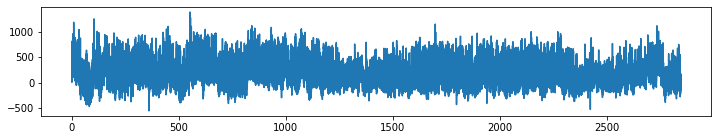

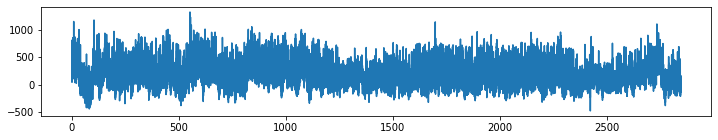

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0  -0.0020  0.1247  0.1033  0.0908  0.2705  0.0064  0.1403  0.1347  0.0648   
5  -0.0160  0.0464  0.0220  0.0585  0.1949  0.1043  0.0959  0.1998  0.0556   
10  0.0056  0.1779  0.1263  0.0735  0.2808  0.2543  0.1035  0.1670  0.1111   
15  0.0017  0.1244  0.1312  0.2318  0.3346  0.2128  0.0794  0.1829  0.1296   
20  0.0170  0.1343  0.1846  0.0945  0.2910  0.1704  0.1004  0.2297  0.1111   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0   0.2948  ...  0.3694  0.4416  0.3360  0.1188  0.4634  0.1794  0.4380   
5   0.3284  ...  0.4039  0.4353  0.3184  0.0837  0.4427  0.2415  0.4494   
10  0.2593  ...  0.3811  0.4137  0.2965  0.0147  0.3542  0.2216  0.4189   
15  0.2854  ...  0.3294  0.3706  0.2754 -0.0192  0.2947  0.1639  0.3750   
20  0.2985  ...  0.4245  0.4480  0.3018  0.0136  0.3916  0.2092  0.4599   

        Oz      O2    PO10  
0   0.1909  0.1227  0.5131  
5   0.2097  0.1022  0.4818  
10  0.1932  0.0757  0.4789  
15  0.1148 -0.0235  0.3054  
20  0.1965  0.0665  0.4606  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



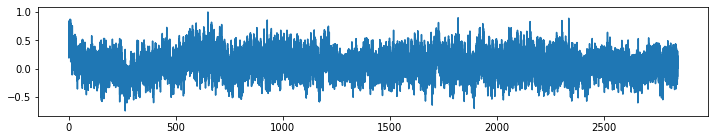



Channel 6 [After Low-Pass] -



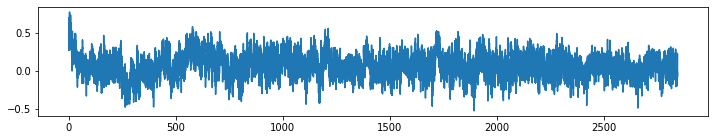



Channel 6 [Before vs After] -



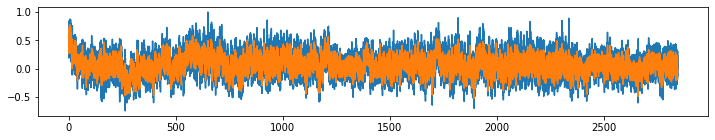

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0  0.002171  0.003339 -0.004513 -0.000141  0.001407 -0.002742 -0.000285   
1  0.002398  0.003344 -0.004244 -0.000519  0.001151 -0.002688 -0.000182   
2  0.002600  0.003341 -0.003996 -0.000871  0.000909 -0.002644 -0.000082   
3  0.002760  0.003326 -0.003781 -0.001184  0.000690 -0.002615  0.000014   

         8         9         10  ...        23        24        25        26  \
0  0.000522  0.000018  0.000222  ... -0.001121 -0.000910 -0.004015  0.002815   
1  0.000355  0.000537  0.000191  ... -0.000943 -0.001047 -0.003695  0.002844   
2  0.000194  0.001025  0.000148  ... -0.000778 -0.001165 -0.003396  0.002864   
3  0.000045  0.001457  0.000091  ... -0.000635 -0.001250 -0.003120  0.002868   

         27        28        29        30        31        32  
0 -0.000361 -0.001771 -0.001782  0.001289  0.001212 -0.002083  
1 -0.000429 -0.001513 -0.001824  0.001444  0.001162 -0.001995  
2 -0.000494 -0.001270 -0.001868  0.001594  0.001108 -0.001899  
3 -0.000555 -0.001051 -0.001912  0.001735  0.001050 -0.001791  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0  0.797407  0.124775  0.020577  0.597407 -0.177242 -0.063915  0.329938   
1  0.771707  0.159662  0.042349  0.578698 -0.161162 -0.067358  0.320388   
2  0.748407  0.192353  0.063427  0.560730 -0.146497 -0.069984  0.311391   
3  0.729252  0.221356  0.083088  0.543912 -0.134180 -0.071365  0.303478   

          8  
0  0.116500  
1  0.112168  
2  0.108226  
3  0.104957

###Visualization

####Signals [Dimensions Reduced]

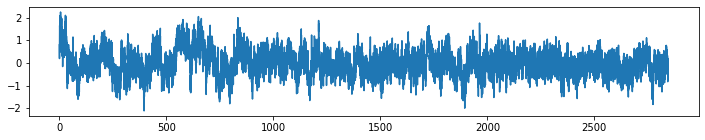

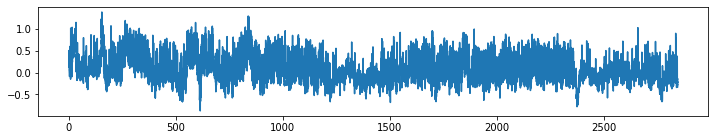

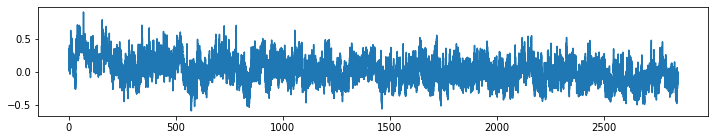

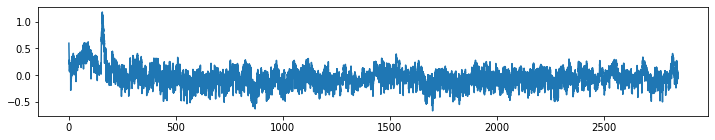

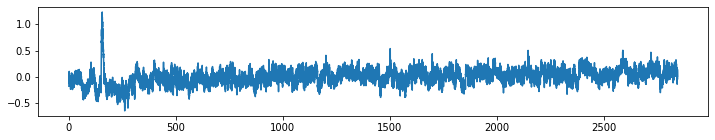

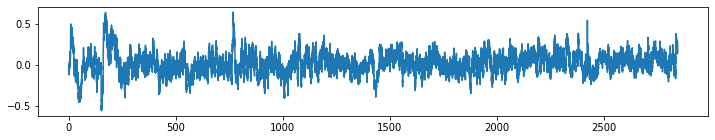

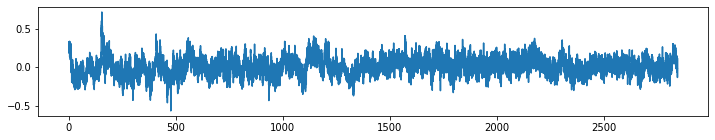

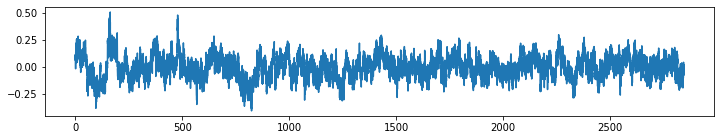

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

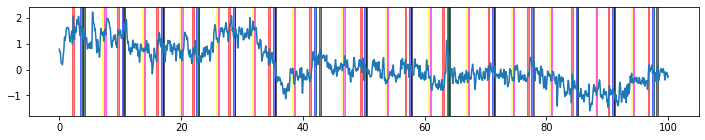

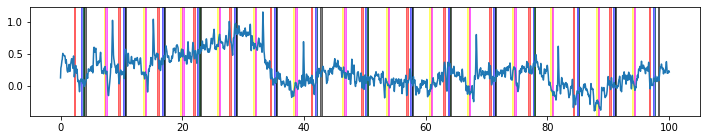

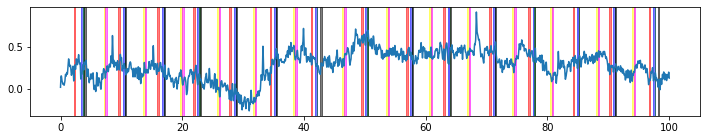

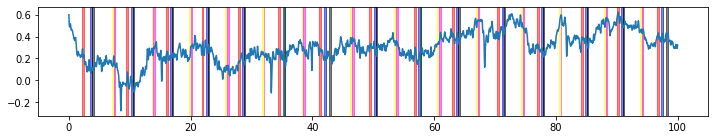

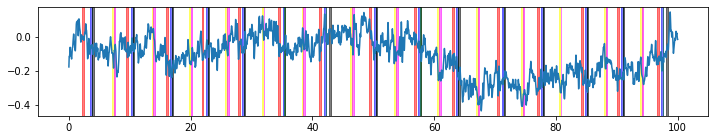

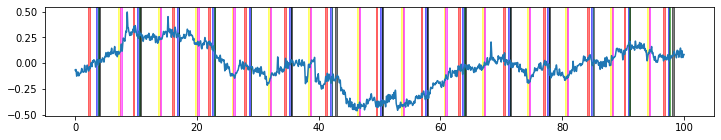

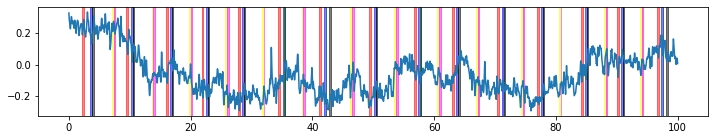

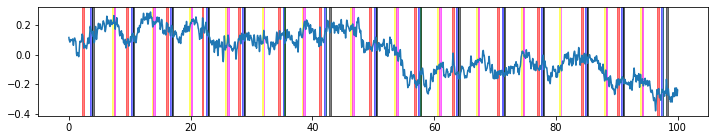

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (237099, 32)
x train : (237099, 6)
x val   : (47380, 32)
y val   : (47380, 6)


In [ ]:
x_train.to_csv(path+'x_train1.csv',index=False)
y_train.to_csv(path+'y_train1.csv',index=False)
x_val.to_csv(path+'x_val1.csv',index=False)
y_val.to_csv(path+'y_val1.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train1.csv')
y_train = pd.read_csv(path+'y_train1.csv')
x_val = pd.read_csv(path+'x_val1.csv')
y_val = pd.read_csv(path+'y_val1.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (261082, 32)
y train : (261082, 6)
x val   : (60503, 32)
y val   : (60503, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.6349530886461333
0.6960485698469949
0.7015257488085662
0.72399684951175
0.814635866697804
0.7240886612695365

0.7158747974634642


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.6123132141034623
0.6855686177205774
0.6803357529602048
0.6890929426468426
0.858281437850835
0.7608613839227796

0.7144088915341169


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7585055614658743
0.6976152728404993
0.7186447602861172
0.8016652395408979
0.8717765769739743
0.8260690036932284

0.7790460691334319


In [ ]:
probs1

array([[0.01633516, 0.00985628, 0.0066088 , 0.00388482, 0.00964016,
        0.00580573],
       [0.01904557, 0.01522843, 0.00952279, 0.00531345, 0.01412791,
        0.00820345],
       [0.02236343, 0.02347199, 0.01372833, 0.00726145, 0.02052719,
        0.011527  ],
       ...,
       [0.01418877, 0.00375329, 0.00500658, 0.00839786, 0.00200162,
        0.00421944],
       [0.01174605, 0.00436233, 0.00640237, 0.01299502, 0.00178526,
        0.00413962],
       [0.00952685, 0.00513952, 0.00834283, 0.02065397, 0.00158731,
        0.00406445]])

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7546459106359791
0.7255282635771557
0.725738775439598
0.8017884805002724
0.8036647616699967
0.7809623800998123

0.7653880953204691


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

Epoch 1/10
2040/2040 [==============================] - 9s 4ms/step - loss: 0.1235 - accuracy: 0.3014
Epoch 2/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.1039 - accuracy: 0.2214
Epoch 3/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.1023 - accuracy: 0.2541
Epoch 4/10
2040/2040 [==============================] - 7s 4ms/step - loss: 0.1007 - accuracy: 0.2519
Epoch 5/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0993 - accuracy: 0.2559
Epoch 6/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0983 - accuracy: 0.2515
Epoch 7/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0976 - accuracy: 0.2454
Epoch 8/10
2040/2040 [==============================] - 7s 4ms/step - loss: 0.0972 - accuracy: 0.2424
Epoch 9/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0968 - accuracy: 0.2375
Epoch 10/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.096

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.7880539464352129
0.7056779550152659
0.7283382093463764
0.8023323884030895
0.8619501889860488
0.8015237648875164

0.7813127421789182


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.7734882359428111
0.7094721851025368
0.7318302023058892
0.7829201588001765
0.8574544400909901
0.7968951689630419

0.775343398534241


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
7410/7410 [==============================] - 16s 2ms/step - loss: 1.1482 - accuracy: 0.1641
Epoch 2/5
7410/7410 [==============================] - 15s 2ms/step - loss: 0.3674 - accuracy: 0.1740
Epoch 3/5
7410/7410 [==============================] - 15s 2ms/step - loss: 0.3097 - accuracy: 0.1927
Epoch 4/5
7410/7410 [==============================] - 15s 2ms/step - loss: 0.3412 - accuracy: 0.1797
Epoch 5/5
7410/7410 [==============================] - 15s 2ms/step - loss: 0.4102 - accuracy: 0.1718


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
464/464 [==============================] - 2s 2ms/step - loss: 0.4523 - accuracy: 0.9479
Epoch 2/5
464/464 [==============================] - 1s 2ms/step - loss: 0.2145 - accuracy: 0.9757
Epoch 3/5
464/464 [==============================] - 1s 2ms/step - loss: 0.1820 - accuracy: 0.9757
Epoch 4/5
464/464 [==============================] - 1s 2ms/step - loss: 0.1676 - accuracy: 0.9757
Epoch 5/5
464/464 [==============================] - 1s 2ms/step - loss: 0.1544 - accuracy: 0.9757
0.6233505020887932
Epoch 1/5
464/464 [==============================] - 1s 2ms/step - loss: 0.3241 - accuracy: 0.9288
Epoch 2/5
464/464 [==============================] - 1s 2ms/step - loss: 0.1545 - accuracy: 0.9757
Epoch 3/5
464/464 [==============================] - 1s 2ms/step - loss: 0.1426 - accuracy: 0.9757
Epoch 4/5
464/464 [==============================] - 1s 2ms/step - loss: 0.1362 - accuracy: 0.9757
Epoch 5/5
464/464 [==============================] - 1s 2ms/step - loss: 0.1319 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5660072696921733
0.5197821579006549
0.5107646150652586
0.5271174762361936
0.6568771352828736
0.5892330280149113

0.5616302803653442


# Subject 2

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj2_data.csv')
train_events = pd.read_csv(path+'Train/subj2_events.csv')
val_data = pd.read_csv(path+'Validation/subj2_data.csv')
val_events = pd.read_csv(path+'Validation/subj2_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1410684, 32)
Train Events      : (1410684, 6)
Validation Data   : (300810, 32)
Validation Events : (300810, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1410684


In [ ]:
x.head(4)

Fp1  Fp2   F7   F3  Fz   F4  F8  FC5  FC1  FC2  ...   P7   P3   Pz   P4  \
0  642  165 -291 -223   5  425  70  176  322  212  ...  343  715  470  262   
1  641  180 -269 -184   4  463  68  198  367  232  ...  378  732  465  270   
2  652  249 -306 -186  -5  492  98  200  361  234  ...  370  723  469  247   
3  624  151 -361 -239  -3  448  96  114  295  178  ...  324  657  407  190   

    P8  PO9   O1   Oz  O2  PO10  
0  374   45  403  505  22   175  
1  348  130  406  496  47   184  
2  303  147  405  481  15   122  
3  245  109  357  449  -5   168  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

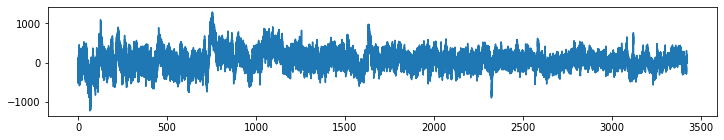

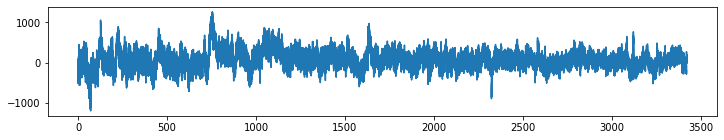

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0   0.1581  0.0440 -0.1445 -0.1771  0.2632  0.3542  0.0473  0.1071  0.4454   
5   0.1005 -0.0003 -0.2696 -0.3463  0.0000  0.1808 -0.0926 -0.0158  0.1950   
10  0.1428  0.0248 -0.1668 -0.1994 -0.7368  0.3567  0.0291  0.0870  0.4163   
15  0.0980 -0.0107 -0.1961 -0.3114  0.0000  0.1642 -0.0805  0.0000  0.1618   
20  0.1576  0.0406 -0.0660 -0.0874 -0.3684  0.3033  0.0372  0.1965  0.5214   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0   0.2533  ...  0.2759  0.4551  0.4223  0.2158  0.2617  0.0278  0.3062   
5   0.0394  ...  0.1472  0.3380  0.2228  0.0354  0.0847  0.0235  0.1869   
10  0.2557  ...  0.2454  0.4176  0.3522  0.1359  0.1400  0.0346  0.2302   
15 -0.0060  ...  0.1279  0.3253  0.2255  0.0667  0.0924 -0.0605  0.1117   
20  0.2401  ...  0.3315  0.4806  0.4465  0.2908  0.2820  0.1401  0.3138   

        Oz      O2    PO10  
0   0.3777  0.0172  0.1262  
5   0.2319 -0.0987  0.1601  
10  0.2917 -0.0376  0.0043  
15  0.1900 -0.1582 -0.0216  
20  0.3829  0.0439  0.1334  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



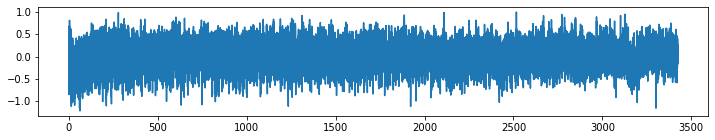



Channel 6 [After Low-Pass] -



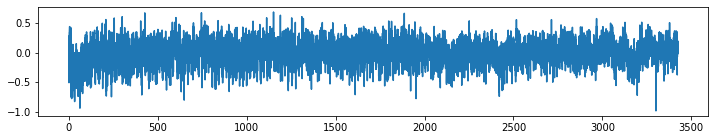



Channel 6 [Before vs After] -



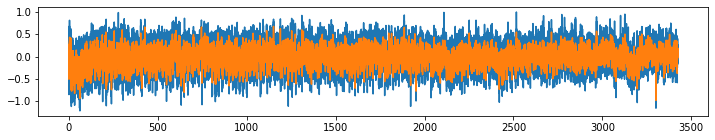

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0 -0.001407  0.001916  0.000756 -0.000484  0.001530 -0.003964 -0.001602   
1 -0.001291  0.001928  0.000596 -0.000335  0.001596 -0.003730 -0.001395   
2 -0.001184  0.001932  0.000454 -0.000196  0.001661 -0.003528 -0.001206   
3 -0.001093  0.001930  0.000339 -0.000075  0.001718 -0.003369 -0.001045   

         8         9         10  ...        23        24        25        26  \
0  0.002298  0.001547  0.001204  ...  0.001694  0.002137 -0.002958 -0.000256   
1  0.002038  0.001623  0.001264  ...  0.001770  0.001890 -0.002866 -0.000243   
2  0.001790  0.001695  0.001320  ...  0.001840  0.001659 -0.002775 -0.000222   
3  0.001558  0.001759  0.001365  ...  0.001897  0.001453 -0.002691 -0.000195   

         27        28        29        30        31        32  
0 -0.003931 -0.018015  0.001291  0.001307 -0.001538  0.001102  
1 -0.003943 -0.017761  0.001298  0.001313 -0.001522  0.001079  
2 -0.003963 -0.017529  0.001302  0.001321 -0.001505  0.001059  
3 -0.003992 -0.017342  0.001306  0.001328 -0.001488  0.001042  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0 -2.034404  1.014591  1.093669 -0.777240 -0.343069  0.306895  0.097751   
1 -1.928149  0.993135  1.058556 -0.750301 -0.333406  0.320257  0.088787   
2 -1.834043  0.971829  1.026381 -0.724637 -0.323644  0.332326  0.080632   
3 -1.759482  0.951862  0.998911 -0.701517 -0.314512  0.343010  0.073064   

          8  
0  0.229609  
1  0.214255  
2  0.200379  
3  0.188695

###Visualization

####Signals [Dimensions Reduced]

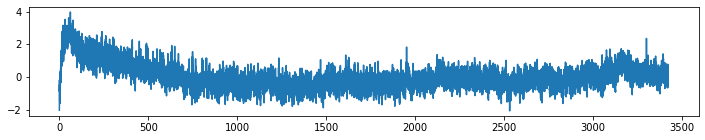

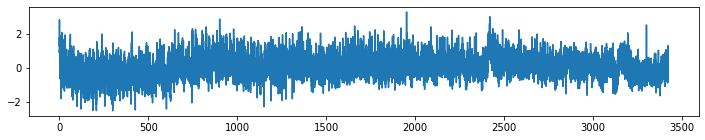

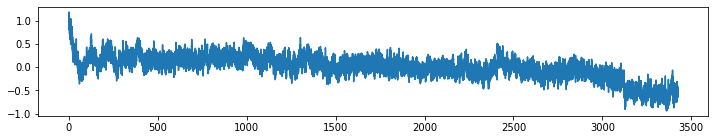

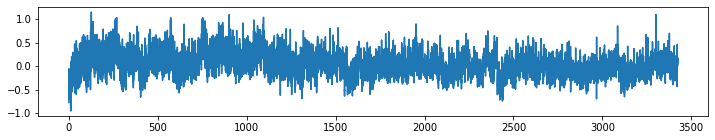

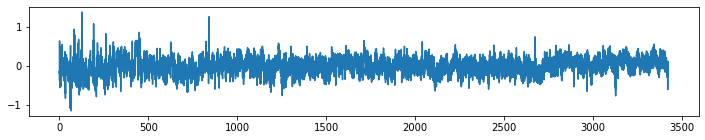

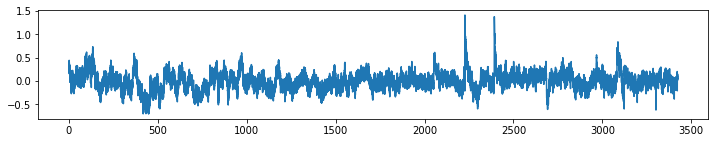

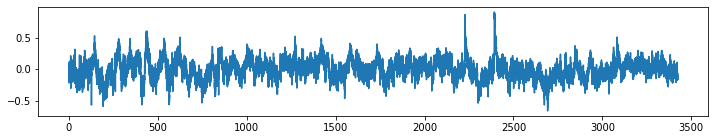

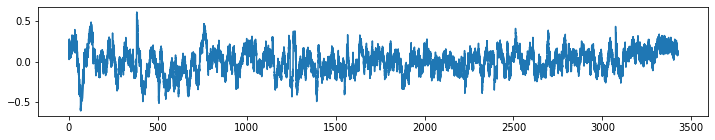

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

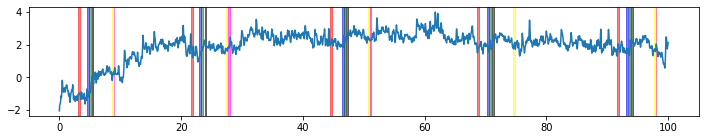

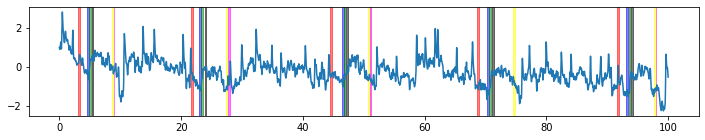

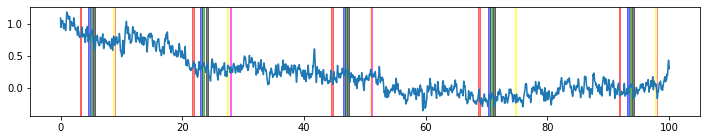

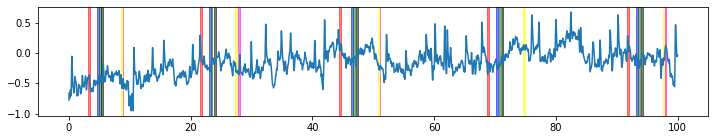

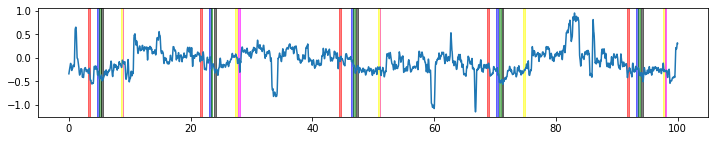

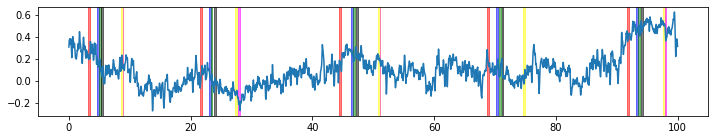

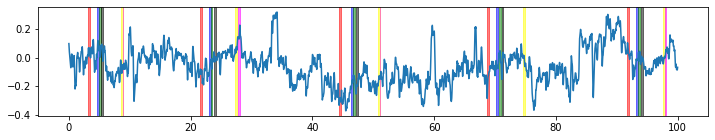

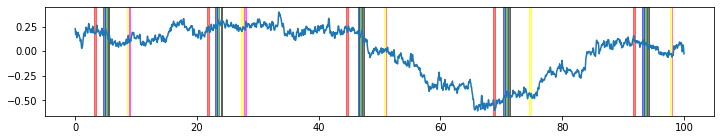

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (282136, 32)
x train : (282136, 6)
x val   : (60163, 32)
y val   : (60163, 6)


In [ ]:
x_train.to_csv(path+'x_train2.csv',index=False)
y_train.to_csv(path+'y_train2.csv',index=False)
x_val.to_csv(path+'x_val2.csv',index=False)
y_val.to_csv(path+'y_val2.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train2.csv')
y_train = pd.read_csv(path+'y_train2.csv')
x_val = pd.read_csv(path+'x_val2.csv')
y_val = pd.read_csv(path+'y_val2.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (282136, 32)
y train : (282136, 6)
x val   : (60163, 32)
y val   : (60163, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7427331423252852
0.7011438386410429
0.627792354145519
0.6516993458429774
0.7183931945539428
0.71115626833291

0.692153023973613


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.733281001783574
0.7400168650120957
0.62419636703502
0.6699632464688644
0.7508859634385902
0.730890968038369

0.7082057352960854


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7529245619414946
0.781356212804961
0.5867605142981095
0.7155283943145587
0.7751801790860693
0.7807385993125465

0.7320814102929566


In [ ]:
probs1

array([[0.01882287, 0.03377955, 0.02654825, 0.02735238, 0.03724178,
        0.02229846],
       [0.01864065, 0.03729563, 0.02809447, 0.03272613, 0.04433031,
        0.02560561],
       [0.01858114, 0.04091907, 0.02965464, 0.03870672, 0.05228163,
        0.02910188],
       ...,
       [0.09707695, 0.01346117, 0.00197844, 0.01647986, 0.06991068,
        0.02885295],
       [0.0811492 , 0.01488319, 0.00235063, 0.01538098, 0.06086849,
        0.02507682],
       [0.0670491 , 0.01664233, 0.00283457, 0.01423211, 0.05263843,
        0.02166088]])

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7351711026615969
0.7367140610868161
0.5882697882415013
0.7159695311464228
0.7794069743238898
0.7852989586316781

0.7234717360153174


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.7746552105693368
0.7780283690132452
0.6559158940488949
0.7191940612419977
0.8439053268710406
0.8314163076410304

0.7671858615642574


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.7519019292420097
0.7501341138282472
0.6458482189393486
0.7001848513952662
0.8380439782368223
0.8216131535455742

0.7512877075312113


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
6912/6912 [==============================] - 13s 2ms/step - loss: 1.4651 - accuracy: 0.1711
Epoch 2/5
6912/6912 [==============================] - 17s 2ms/step - loss: 0.4048 - accuracy: 0.1833
Epoch 3/5
6912/6912 [==============================] - 15s 2ms/step - loss: 0.3632 - accuracy: 0.1838
Epoch 4/5
6912/6912 [==============================] - 12s 2ms/step - loss: 0.4456 - accuracy: 0.1756
Epoch 5/5
6912/6912 [==============================] - 12s 2ms/step - loss: 0.5829 - accuracy: 0.1748


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
432/432 [==============================] - 1s 2ms/step - loss: 0.3023 - accuracy: 0.9596
Epoch 2/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1680 - accuracy: 0.9740
Epoch 3/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1539 - accuracy: 0.9740
Epoch 4/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1461 - accuracy: 0.9740
Epoch 5/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1399 - accuracy: 0.9740
0.6784450699419993
Epoch 1/5
432/432 [==============================] - 1s 2ms/step - loss: 0.2950 - accuracy: 0.9664
Epoch 2/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1740 - accuracy: 0.9740
Epoch 3/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1539 - accuracy: 0.9740
Epoch 4/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1444 - accuracy: 0.9740
Epoch 5/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1385 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5650045624778364
0.5208585242654628
0.5159602069764828
0.5290684382487004
0.6537720501742823
0.5899704357923142

0.5624390363225132


# Subject 3

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj3_data.csv')
train_events = pd.read_csv(path+'Train/subj3_events.csv')
val_data = pd.read_csv(path+'Validation/subj3_data.csv')
val_events = pd.read_csv(path+'Validation/subj3_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1105800, 32)
Train Events      : (1105800, 6)
Validation Data   : (230025, 32)
Validation Events : (230025, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1105800


In [ ]:
x.head(4)

Fp1  Fp2    F7   F3   Fz   F4   F8  FC5  FC1  FC2  ...   P7  P3   Pz   P4  \
0  1001   84  1103 -203  432  607   -1  678  498  193  ...  614  10  311 -302   
1   969   75  1086 -230  421  629    5  649  500  192  ...  467 -20  291 -322   
2   960   28  1065 -247  444  600 -158  656  503  179  ...  551  -5  305 -295   
3   975   48   999 -254  415  577  -32  640  515  178  ...  529 -23  285 -312   

    P8   PO9   O1   Oz   O2  PO10  
0 -538  1757  188  331 -279    96  
1 -627  1788  188  319 -288   170  
2 -545  1761  193  326 -311    86  
3 -559  1735  204  313 -322    32  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

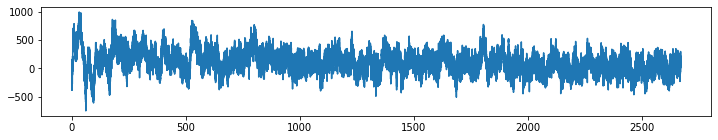

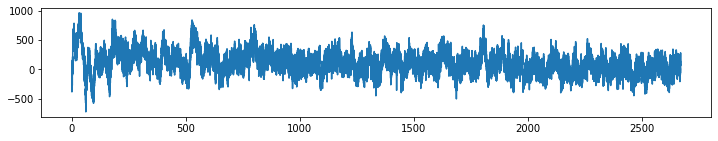

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0   0.6160  0.0456  0.5250 -0.2101  0.3902  0.3837 -0.0006  0.4748  0.4275   
5   0.5963  0.0440  0.5217 -0.2391  0.3911  0.3774 -0.0177  0.4321  0.4300   
10  0.5877  0.0532  0.4769 -0.2712  0.3622  0.3736  0.0177  0.3852  0.4086   
15  0.5969  0.0358  0.4993 -0.2443  0.3650  0.3552 -0.0022  0.4097  0.4206   
20  0.6302  0.0581  0.4936 -0.2350  0.3939  0.3831  0.0155  0.4139  0.4395   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0   0.1368  ...  0.2693  0.0097  0.1868 -0.2654 -0.1841  0.4524  0.1541   
5   0.1325  ...  0.2404 -0.0097  0.1664 -0.2355 -0.1718  0.4501  0.1803   
10  0.1481  ...  0.2754  0.0438  0.1940 -0.2056 -0.1807  0.4567  0.2311   
15  0.1417  ...  0.2667  0.0302  0.1724 -0.2364 -0.1674  0.4596  0.2115   
20  0.1311  ...  0.1956 -0.0632  0.1550 -0.2654 -0.1903  0.4493  0.2049   

        Oz      O2    PO10  
0   0.2554 -0.1754  0.0190  
5   0.3179 -0.1508  0.0410  
10  0.3534 -0.1100  0.0539  
15  0.3210 -0.1571  0.0198  
20  0.3287 -0.1603  0.0147  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



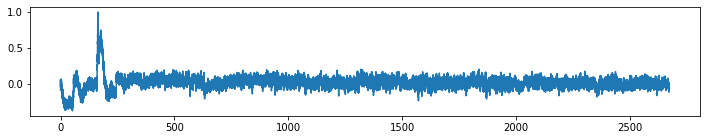



Channel 6 [After Low-Pass] -



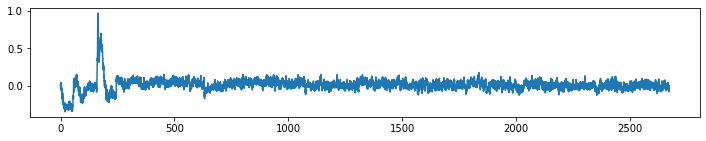



Channel 6 [Before vs After] -



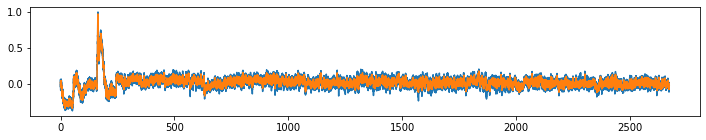

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0  0.000989 -0.001241  0.001667 -0.000223 -0.001017 -0.001090 -0.000697   
1  0.000845 -0.001026  0.001462 -0.000051 -0.001015 -0.001167 -0.000461   
2  0.000715 -0.000828  0.001274  0.000114 -0.001012 -0.001229 -0.000234   
3  0.000604 -0.000656  0.001112  0.000273 -0.001010 -0.001270 -0.000025   

         8         9         10  ...        23        24        25        26  \
0 -0.000964 -0.003751  0.001501  ...  0.003263  0.006614  0.006893 -0.002417   
1 -0.000939 -0.003675  0.001360  ...  0.003152  0.006501  0.007013 -0.002328   
2 -0.000919 -0.003613  0.001233  ...  0.003044  0.006391  0.007122 -0.002236   
3 -0.000909 -0.003580  0.001140  ...  0.002945  0.006289  0.007213 -0.002140   

         27        28        29        30        31        32  
0 -0.004807 -0.000469  0.000151  0.001108  0.000685  0.000785  
1 -0.004549 -0.000821  0.000244  0.001127  0.000710  0.000828  
2 -0.004314 -0.001141  0.000320  0.001140  0.000731  0.000870  
3 -0.004116 -0.001398  0.000365  0.001143  0.000746  0.000910  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0  0.165929 -0.011226 -0.096770  0.514366  0.554901 -0.195151 -0.051481   
1  0.145164 -0.006381 -0.096205  0.506154  0.555077 -0.183621 -0.062916   
2  0.122037 -0.002104 -0.096285  0.500116  0.555588 -0.172851 -0.073065   
3  0.095040  0.001664 -0.097386  0.497824  0.556813 -0.163369 -0.080826   

          8  
0 -0.071316  
1 -0.057270  
2 -0.044245  
3 -0.033467

###Visualization

####Signals [Dimensions Reduced]

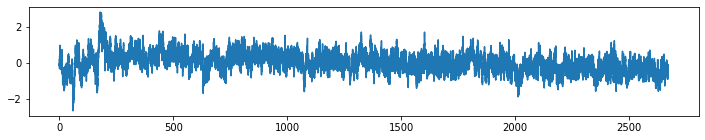

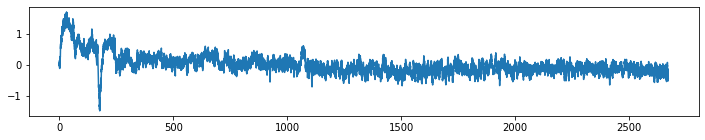

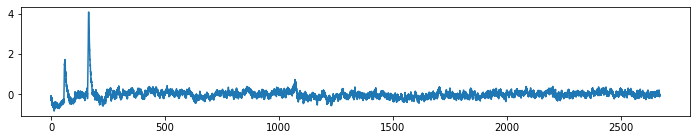

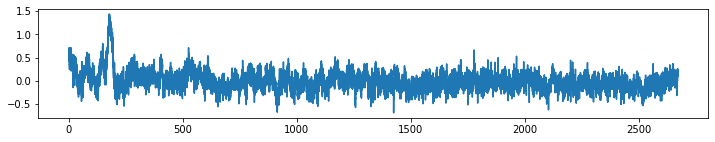

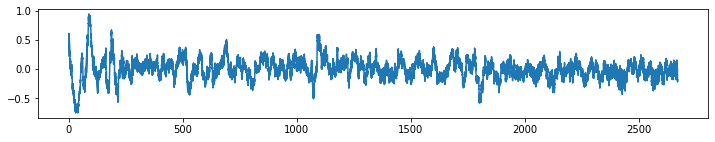

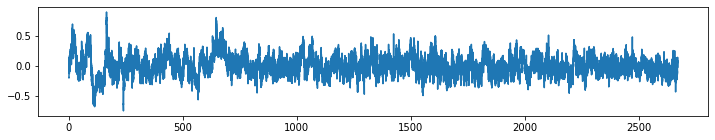

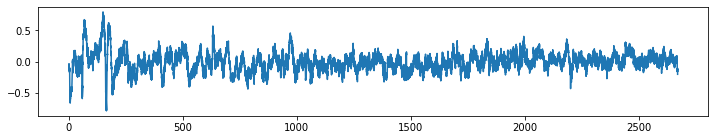

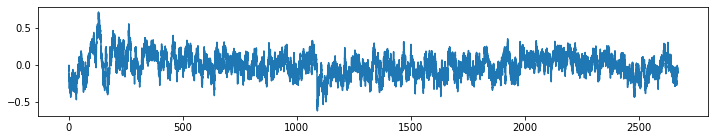

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

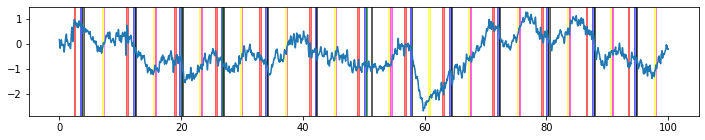

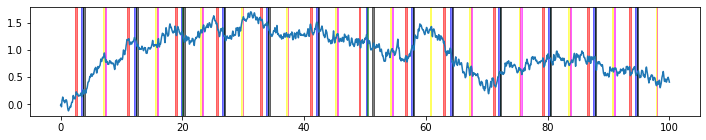

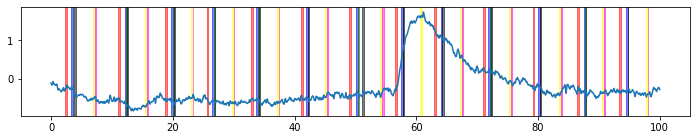

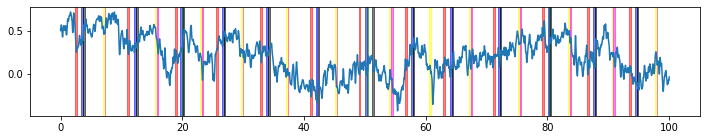

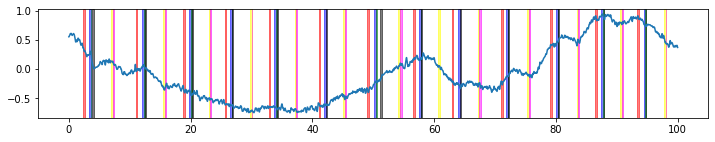

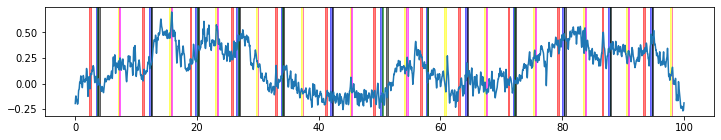

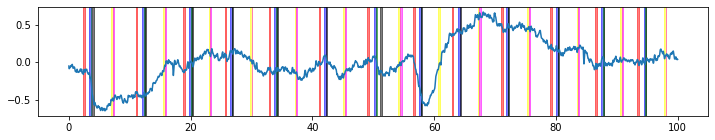

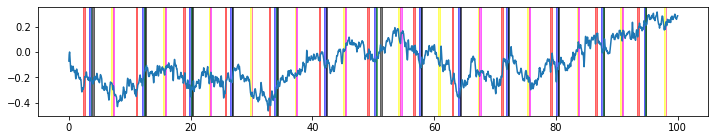

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (221160, 32)
x train : (221160, 6)
x val   : (46005, 32)
y val   : (46005, 6)


In [ ]:
x_train.to_csv(path+'x_train3.csv',index=False)
y_train.to_csv(path+'y_train3.csv',index=False)
x_val.to_csv(path+'x_val3.csv',index=False)
y_val.to_csv(path+'y_val3.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train3.csv')
y_train = pd.read_csv(path+'y_train3.csv')
x_val = pd.read_csv(path+'x_val3.csv')
y_val = pd.read_csv(path+'y_val3.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (221160, 32)
y train : (221160, 6)
x val   : (46005, 32)
y val   : (46005, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.6914254988928359
0.7639494651494171
0.7729019741639406
0.7311568359858445
0.6348522220215278
0.553233699712115

0.6912532826542801


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.655095257368272
0.7514622315433622
0.7623302125353724
0.7256285079709126
0.576254791578863
0.5144136434284848

0.6641974407375445


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.742041173571669
0.7496457186309075
0.7418549626150927
0.7163627818920131
0.6272816612144687
0.6337043280862897

0.7018151043350733


In [ ]:
probs1

array([[0.05857762, 0.03574707, 0.03153996, 0.03064893, 0.01237906,
        0.01430399],
       [0.04876711, 0.03090611, 0.02812577, 0.02872157, 0.01207402,
        0.01404596],
       [0.04092115, 0.02671077, 0.02499062, 0.02680093, 0.01183088,
        0.01371617],
       ...,
       [0.13543461, 0.02047591, 0.01309854, 0.01179002, 0.01178545,
        0.00478955],
       [0.12444537, 0.01900511, 0.01219604, 0.01106661, 0.01154154,
        0.00467218],
       [0.11409685, 0.01768727, 0.01140895, 0.01043967, 0.01130862,
        0.00458854]])

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.740902779171489
0.7529190331881643
0.7432674275214464
0.7155203671369605
0.6413688138737811
0.6487674910746739

0.7071243186610859


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.6947066572563292
0.7555869475050341
0.7538655804639609
0.7005493173045403
0.5809188347236995
0.6297025708952977

0.6858883180248103


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.6979649308830778
0.7371196395082541
0.748263318861037
0.6961255388087226
0.5893054133970204
0.6209757483113797

0.6816257649615819


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
6912/6912 [==============================] - 20s 3ms/step - loss: 1.3418 - accuracy: 0.1566
Epoch 2/5
6912/6912 [==============================] - 21s 3ms/step - loss: 0.3836 - accuracy: 0.1675
Epoch 3/5
6912/6912 [==============================] - 15s 2ms/step - loss: 0.3623 - accuracy: 0.1843
Epoch 4/5
6912/6912 [==============================] - 12s 2ms/step - loss: 0.4576 - accuracy: 0.1719
Epoch 5/5
6912/6912 [==============================] - 12s 2ms/step - loss: 0.5800 - accuracy: 0.1689


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
432/432 [==============================] - 2s 2ms/step - loss: 0.2997 - accuracy: 0.9389
Epoch 2/5
432/432 [==============================] - 2s 4ms/step - loss: 0.1698 - accuracy: 0.9739
Epoch 3/5
432/432 [==============================] - 1s 3ms/step - loss: 0.1536 - accuracy: 0.9740
Epoch 4/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1466 - accuracy: 0.9740
Epoch 5/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1412 - accuracy: 0.9740
0.6877459509904269
Epoch 1/5
432/432 [==============================] - 1s 2ms/step - loss: 0.2049 - accuracy: 0.9740
Epoch 2/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1352 - accuracy: 0.9740
Epoch 3/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1296 - accuracy: 0.9740
Epoch 4/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1264 - accuracy: 0.9740
Epoch 5/5
432/432 [==============================] - 1s 2ms/step - loss: 0.1241 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5784183943109825
0.555729735997663
0.5643352109409668
0.5630777211373574
0.5226796660891128
0.5239110433210019

0.5513586286328475


# Subject 4

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj4_data.csv')
train_events = pd.read_csv(path+'Train/subj4_events.csv')
val_data = pd.read_csv(path+'Validation/subj4_data.csv')
val_events = pd.read_csv(path+'Validation/subj4_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1159109, 32)
Train Events      : (1159109, 6)
Validation Data   : (243415, 32)
Validation Events : (243415, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1159109


In [ ]:
x.head(4)

Fp1  Fp2    F7   F3   Fz   F4   F8  FC5  FC1  FC2  ...   P7   P3   Pz   P4  \
0  708  885  1053  592  327  637  738  906   51  495  ...  893  333  213  450   
1  779  797  1061  538  364  716  736  930   60  513  ...  938  369  226  479   
2  819  797  1131  559  346  685  730  710   53  499  ...  906  368  252  477   
3  827  818  1138  507  285  620  747  732   23  468  ...  846  305  192  449   

    P8  PO9   O1   Oz   O2  PO10  
0  657  417  521  372  308   419  
1  665  510  552  393  324   433  
2  704  567  539  419  332   410  
3  695  505  503  368  284   382  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

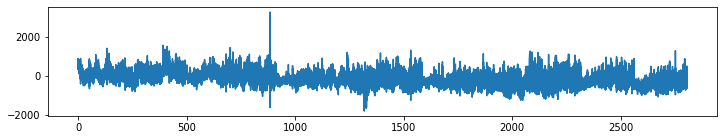

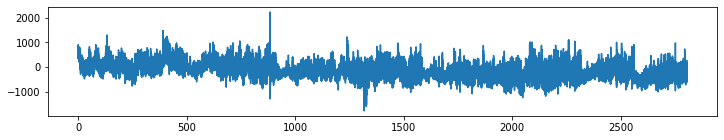

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0   0.2293  0.2464  0.4778  0.2661  0.3184  0.3146  0.6089  0.4539  0.0419   
5   0.2879  0.2568  0.5681  0.2225  0.3213  0.3081  0.6205  0.4424  0.0599   
10  0.2639  0.2437  0.4964  0.2207  0.3019  0.3022  0.5594  0.4679  0.0681   
15  0.1700  0.2389  0.4850  0.3137  0.3223  0.3314  0.5586  0.3081  0.0534   
20  0.2322  0.2918  0.5386  0.2796  0.3350  0.2923  0.5091  0.4314  0.0493   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0   0.3009  ...  0.5432  0.2602  0.1983  0.3078  0.4201  0.2101  0.3611   
5   0.3082  ...  0.5201  0.2875  0.2374  0.3482  0.4655  0.3018  0.4068   
10  0.2894  ...  0.5675  0.3492  0.3259  0.4213  0.5767  0.3249  0.4304   
15  0.3046  ...  0.4970  0.3430  0.3650  0.4535  0.5595  0.3169  0.4511   
20  0.3173  ...  0.5937  0.3828  0.3966  0.5109  0.6394  0.3924  0.5308   

        Oz      O2    PO10  
0   0.2756  0.1901  0.2075  
5   0.3089  0.2117  0.2031  
10  0.3481  0.2519  0.1436  
15  0.3704  0.2969  0.2719  
20  0.4541  0.3531  0.3224  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



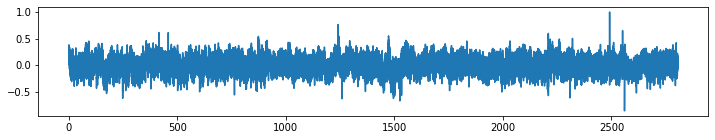



Channel 6 [After Low-Pass] -



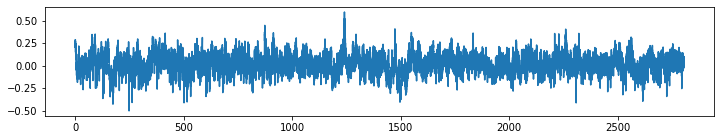



Channel 6 [Before vs After] -



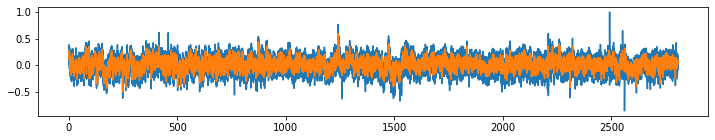

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0 -0.000208  0.004071 -0.000646  0.002432  0.002806 -0.001466  0.000641   
1 -0.000549  0.003742 -0.000571  0.002465  0.002684 -0.001461  0.000820   
2 -0.000871  0.003427 -0.000510  0.002497  0.002568 -0.001460  0.000973   
3 -0.001160  0.003144 -0.000470  0.002529  0.002467 -0.001463  0.001089   

         8         9         10  ...        23        24        25        26  \
0  0.008761 -0.002329 -0.002328  ...  0.000226  0.001340  0.000517  0.000268   
1  0.008251 -0.002001 -0.002068  ...  0.000108  0.001562  0.000486  0.000430   
2  0.007767 -0.001685 -0.001820  ... -0.000006  0.001771  0.000455  0.000587   
3  0.007335 -0.001400 -0.001597  ... -0.000115  0.001958  0.000426  0.000731   

         27        28        29        30        31        32  
0 -0.002847  0.001944  0.001067  0.002288  0.001499  0.001756  
1 -0.003040  0.001918  0.000974  0.002140  0.001405  0.001587  
2 -0.003229  0.001897  0.000888  0.002004  0.001313  0.001440  
3 -0.003405  0.001882  0.000811  0.001879  0.001230  0.001328  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0  1.570666 -0.192050 -0.259801  0.291227  0.210421 -0.047157  0.060632   
1  1.642241 -0.147751 -0.279247  0.282288  0.192190 -0.029098  0.053254   
2  1.710836 -0.105882 -0.298104  0.273588  0.174327 -0.012748  0.045531   
3  1.773314 -0.068606 -0.315421  0.265537  0.157751  0.001289  0.037721   

          8  
0  0.150722  
1  0.124778  
2  0.099188  
3  0.075030

###Visualization

####Signals [Dimensions Reduced]

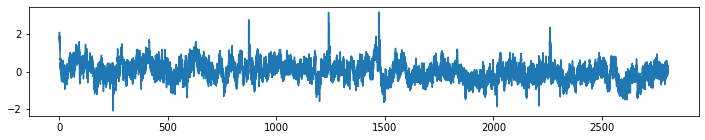

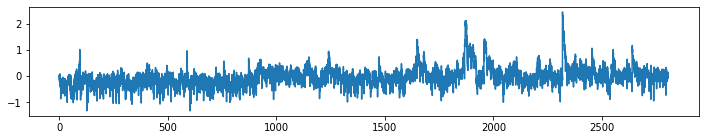

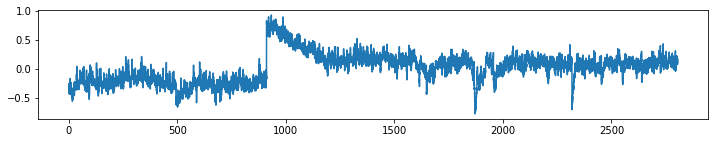

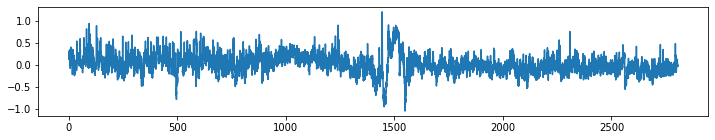

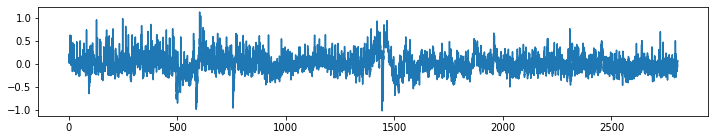

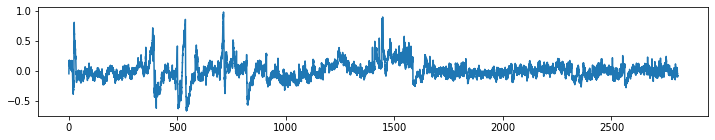

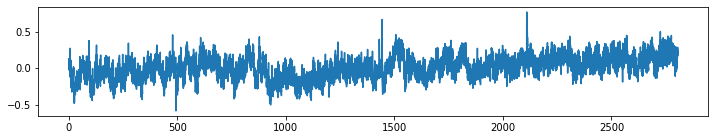

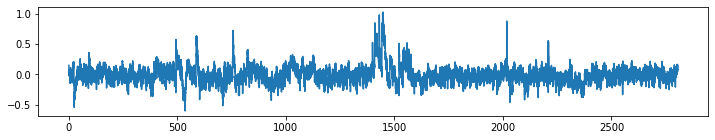

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

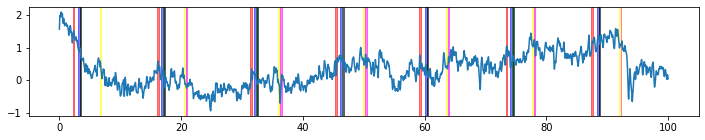

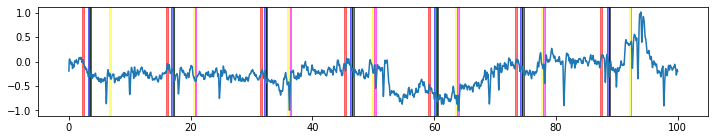

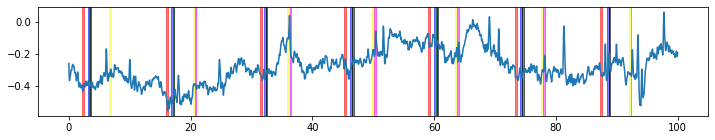

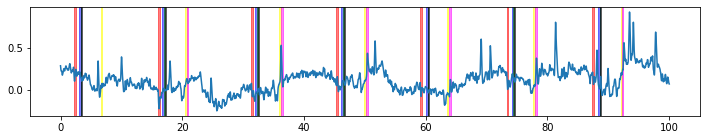

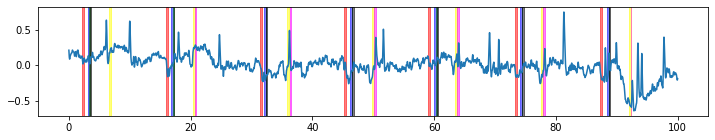

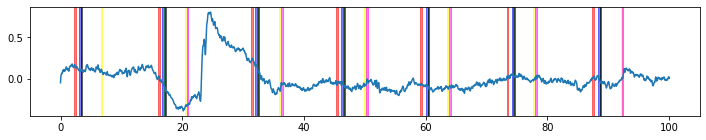

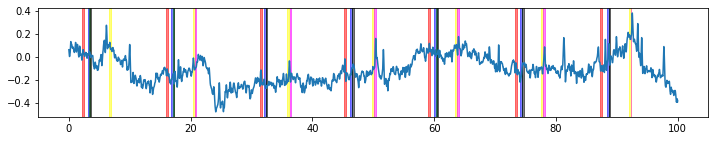

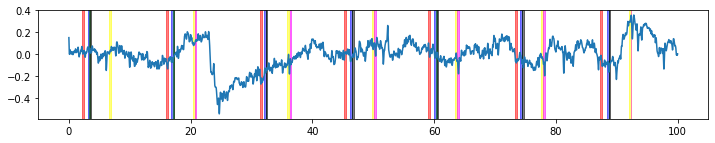

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (231821, 32)
x train : (231821, 6)
x val   : (48684, 32)
y val   : (48684, 6)


In [ ]:
x_train.to_csv(path+'x_train4.csv',index=False)
y_train.to_csv(path+'y_train4.csv',index=False)
x_val.to_csv(path+'x_val4.csv',index=False)
y_val.to_csv(path+'y_val4.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train4.csv')
y_train = pd.read_csv(path+'y_train4.csv')
x_val = pd.read_csv(path+'x_val4.csv')
y_val = pd.read_csv(path+'y_val4.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (231821, 32)
y train : (231821, 6)
x val   : (48684, 32)
y val   : (48684, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7035788181150171
0.6879982672255935
0.6540142291802237
0.6125587365123564
0.6082019039499859
0.5908146772129657

0.6428611053660237


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.6988141193789925
0.6756619023777937
0.6361164340747019
0.5719555117948045
0.5911145602654062
0.5712991898586036

0.6241602862917172


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7347956402353412
0.7837139068387838
0.7484894764011427
0.7383685626295797
0.6933255501411609
0.7265285575682978

0.737536948969051


In [ ]:
probs1

array([[0.00911987, 0.00255991, 0.00282426, 0.00654595, 0.00614174,
        0.00354326],
       [0.01246187, 0.00281209, 0.00353643, 0.0091374 , 0.00513745,
        0.00322953],
       [0.01646081, 0.00301206, 0.00428649, 0.0123853 , 0.00432041,
        0.00293508],
       ...,
       [0.01963598, 0.00878416, 0.00410554, 0.00611841, 0.0132511 ,
        0.00609831],
       [0.01951957, 0.01055182, 0.00458465, 0.0066603 , 0.01309631,
        0.00597398],
       [0.01944335, 0.01279401, 0.00513627, 0.00724894, 0.01287645,
        0.00582369]])

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.725920751844173
0.7806511271861459
0.7465688586557168
0.7442444103102178
0.6973910016798075
0.7280254505970127

0.7371336000455123


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.7794262307658677
0.814846638745542
0.7797886179169378
0.7745998213838318
0.6870172602743181
0.7202160061777905

0.759315762544048


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.7703457488174928
0.8017933868299056
0.7706186334623035
0.7669800226496568
0.6955227045153023
0.7164445629894184

0.7536175098773467


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
7245/7245 [==============================] - 15s 2ms/step - loss: 1.0500 - accuracy: 0.1771
Epoch 2/5
7245/7245 [==============================] - 13s 2ms/step - loss: 0.3671 - accuracy: 0.1866
Epoch 3/5
7245/7245 [==============================] - 14s 2ms/step - loss: 0.3190 - accuracy: 0.1931
Epoch 4/5
7245/7245 [==============================] - 13s 2ms/step - loss: 0.3540 - accuracy: 0.1884
Epoch 5/5
7245/7245 [==============================] - 13s 2ms/step - loss: 0.4222 - accuracy: 0.1720


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
453/453 [==============================] - 1s 2ms/step - loss: 0.2762 - accuracy: 0.9725
Epoch 2/5
453/453 [==============================] - 1s 2ms/step - loss: 0.1436 - accuracy: 0.9752
Epoch 3/5
453/453 [==============================] - 1s 2ms/step - loss: 0.1246 - accuracy: 0.9752
Epoch 4/5
453/453 [==============================] - 1s 2ms/step - loss: 0.1165 - accuracy: 0.9752
Epoch 5/5
453/453 [==============================] - 1s 2ms/step - loss: 0.1133 - accuracy: 0.9752
0.7596107605206563
Epoch 1/5
453/453 [==============================] - 1s 2ms/step - loss: 0.2874 - accuracy: 0.9718
Epoch 2/5
453/453 [==============================] - 1s 2ms/step - loss: 0.1361 - accuracy: 0.9752
Epoch 3/5
453/453 [==============================] - 1s 2ms/step - loss: 0.1234 - accuracy: 0.9752
Epoch 4/5
453/453 [==============================] - 1s 2ms/step - loss: 0.1180 - accuracy: 0.9752
Epoch 5/5
453/453 [==============================] - 1s 2ms/step - loss: 0.1142 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5756500163524805
0.5819864291227168
0.5808778707220819
0.5565452484484062
0.5510392547808937
0.5402707680705418

0.5643949312495201


# Subject 5

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj5_data.csv')
train_events = pd.read_csv(path+'Train/subj5_events.csv')
val_data = pd.read_csv(path+'Validation/subj5_data.csv')
val_events = pd.read_csv(path+'Validation/subj5_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1253962, 32)
Train Events      : (1253962, 6)
Validation Data   : (264764, 32)
Validation Events : (264764, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1253962


In [ ]:
x.head(4)

Fp1  Fp2  F7   F3   Fz  F4    F8  FC5  FC1  FC2  ...  P7   P3  Pz  P4   P8  \
0   65  465  18 -235 -206  14 -1146   88  -53 -305  ... -15  258 -44  41  197   
1   59  474  32 -231 -205   0 -1124  112  -40 -317  ...  38  263 -43  75  108   
2   34  482  27 -224 -216  -7 -1132  115  -60 -313  ...  36  266 -34  56    5   
3   22  441 -28 -241 -219  16 -1207  100  -77 -310  ...  37  304 -10  65   -7   

   PO9  O1   Oz   O2  PO10  
0 -480 -81 -137 -109    12  
1 -403 -46 -107  -94   -27  
2 -385 -18 -105  -97   -55  
3 -330  -1  -81  -75    20  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

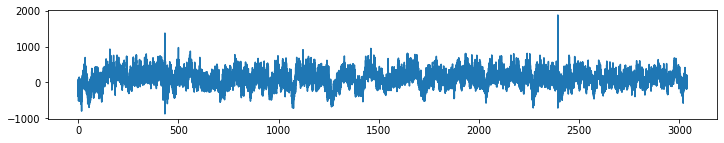

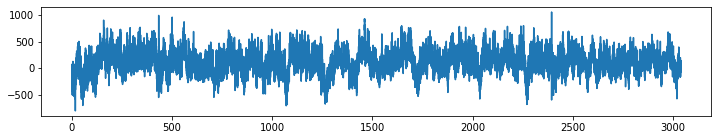

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0   0.0028  0.0658  0.0082 -0.2219 -0.2040  0.0074 -0.7212  0.0440 -0.0925   
5   0.0008  0.0599 -0.0141 -0.2908 -0.2327  0.0011 -0.7791  0.0315 -0.1606   
10  0.0041  0.0661 -0.0041 -0.2540 -0.2119  0.0259 -0.7338  0.0370 -0.0820   
15  0.0045  0.0728 -0.0150 -0.2956 -0.2347  0.0396 -0.7074  0.0140 -0.1588   
20  0.0115  0.0918  0.0395 -0.2427 -0.2178  0.0422 -0.7502  0.0475 -0.1606   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0  -0.4834  ... -0.0122  0.2471 -0.0417  0.0357  0.1405 -0.3727 -0.0652   
5  -0.4929  ...  0.0349  0.2682 -0.0266  0.0366  0.0528 -0.2904 -0.0225   
10 -0.4390  ... -0.0641  0.2500 -0.0237  0.0513 -0.0535 -0.3090 -0.0652   
15 -0.4453  ...  0.0162  0.2969 -0.0095  0.0522  0.0535 -0.3579 -0.0676   
20 -0.5024  ... -0.0032  0.2672 -0.0332  0.0061  0.1006 -0.3292 -0.0475   

        Oz      O2    PO10  
0  -0.1606 -0.1124  0.0116  
5  -0.1336 -0.1258 -0.0194  
10 -0.2122 -0.1598 -0.1742  
15 -0.2028 -0.1598 -0.1752  
20 -0.1805 -0.1041 -0.0687  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



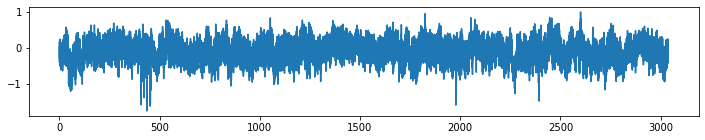



Channel 6 [After Low-Pass] -



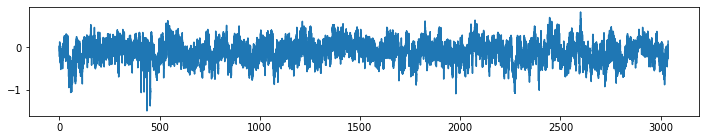



Channel 6 [Before vs After] -



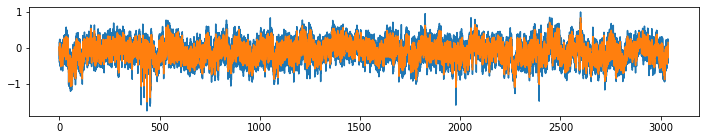

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0  0.005404  0.005258 -0.002369 -0.000266 -0.000409 -0.001394 -0.000712   
1  0.005458  0.004835 -0.002362 -0.000268 -0.000305 -0.001157 -0.000594   
2  0.005495  0.004470 -0.002355 -0.000265 -0.000218 -0.000938 -0.000480   
3  0.005511  0.004182 -0.002355 -0.000256 -0.000151 -0.000748 -0.000375   

         8         9         10  ...        23        24        25        26  \
0 -0.000257  0.009950 -0.000407  ...  0.001010  0.001159 -0.002332 -0.000293   
1 -0.000147  0.010093 -0.000428  ...  0.000935  0.001042 -0.002316 -0.000091   
2 -0.000043  0.010234 -0.000455  ...  0.000873  0.000931 -0.002307  0.000099   
3  0.000048  0.010371 -0.000487  ...  0.000829  0.000835 -0.002307  0.000274   

         27        28        29        30        31        32  
0 -0.001264 -0.002937  0.000358  0.000988  0.000670 -0.000864  
1 -0.001057 -0.002761  0.000503  0.001167  0.000672 -0.001283  
2 -0.000875 -0.002589  0.000642  0.001336  0.000676 -0.001673  
3 -0.000731 -0.002419  0.000771  0.001483  0.000683 -0.002011  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0  0.883623 -0.728794 -0.392689 -0.182260  0.074580  0.116898  0.186145   
1  0.924790 -0.694423 -0.412736 -0.171707  0.076671  0.114050  0.150410   
2  0.963764 -0.661366 -0.428351 -0.159996  0.077913  0.112190  0.116100   
3  0.998293 -0.631088 -0.436819 -0.146437  0.077875  0.111645  0.083870   

          8  
0 -0.086325  
1 -0.070169  
2 -0.055248  
3 -0.042660

###Visualization

####Signals [Dimensions Reduced]

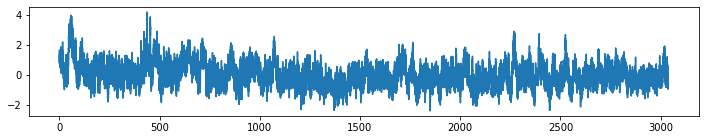

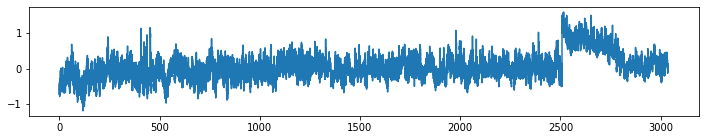

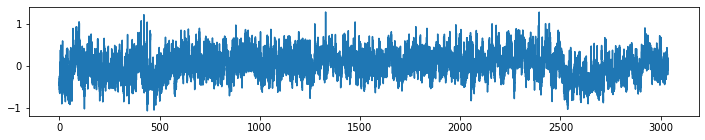

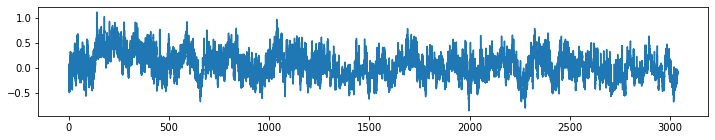

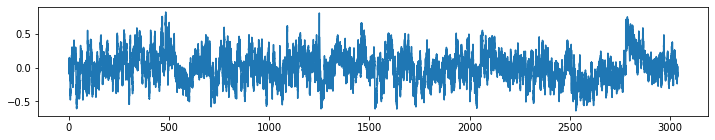

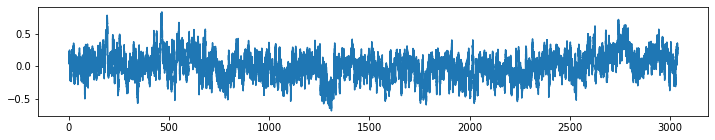

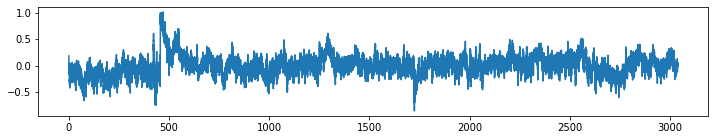

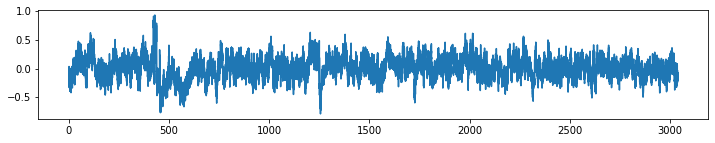

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

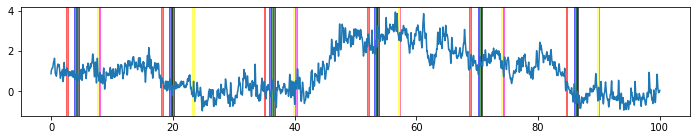

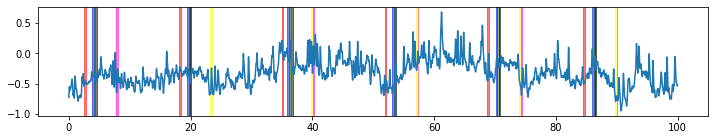

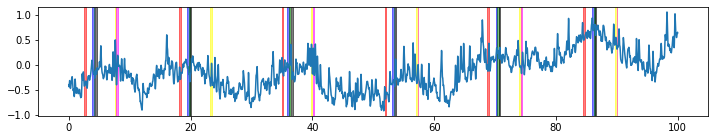

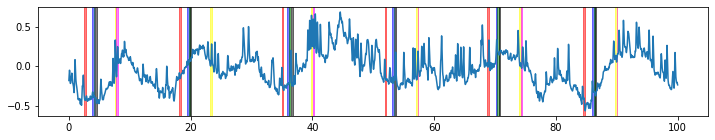

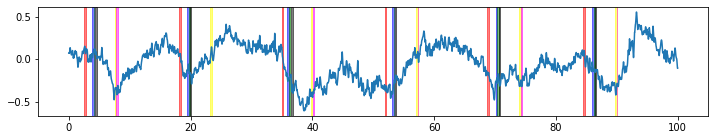

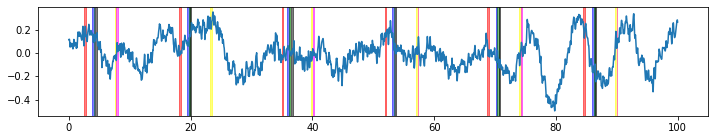

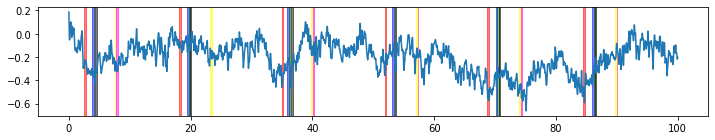

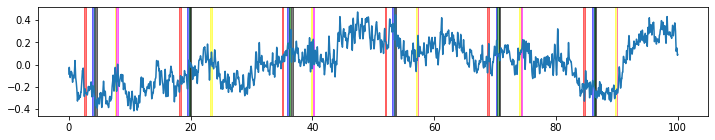

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (250792, 32)
x train : (250792, 6)
x val   : (52954, 32)
y val   : (52954, 6)


In [ ]:
x_train.to_csv(path+'x_train5.csv',index=False)
y_train.to_csv(path+'y_train5.csv',index=False)
x_val.to_csv(path+'x_val5.csv',index=False)
y_val.to_csv(path+'y_val5.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train5.csv')
y_train = pd.read_csv(path+'y_train5.csv')
x_val = pd.read_csv(path+'x_val5.csv')
y_val = pd.read_csv(path+'y_val5.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (250792, 32)
y train : (250792, 6)
x val   : (52954, 32)
y val   : (52954, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5832960636428827
0.6101204395416492
0.6168119135150624
0.6398430224900582
0.5575069686907642
0.532392280870395

0.589995114791802


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5784000095894114
0.603194698942546
0.6109734446475295
0.6213523409717424
0.4794780192589272
0.4963441187253862

0.5649571053559238


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.610810068419873
0.6626832771447739
0.6724865728983977
0.6966297840187259
0.5890278069824779
0.622806008132129

0.6424072529327296


In [ ]:
probs1

array([[0.00335512, 0.00363559, 0.00374738, 0.00449113, 0.00598316,
        0.00421367],
       [0.0031837 , 0.00464503, 0.00457775, 0.0054684 , 0.00665392,
        0.00446719],
       [0.00301564, 0.00589519, 0.00554721, 0.0066018 , 0.00736218,
        0.00470215],
       ...,
       [0.02776665, 0.00635489, 0.00804199, 0.00890383, 0.00531266,
        0.00449194],
       [0.02623874, 0.00593068, 0.00783342, 0.00881808, 0.00534803,
        0.00459486],
       [0.02479397, 0.00557319, 0.00773477, 0.0088802 , 0.0053423 ,
        0.00465823]])

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.6043214932985803
0.6526761101187932
0.6676544626964191
0.6929282038069577
0.5930760598225228
0.6259474839155916

0.6394339689431442


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.5832401350373987
0.6322260018239138
0.6418993880106939
0.6754465575168277
0.5470769962343267
0.6030646690266631

0.613825624608304


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.5711883341151207
0.629314984822542
0.6244771411923373
0.6434980324376285
0.5506758898319118
0.584226857553722

0.6005635399922103


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
7838/7838 [==============================] - 15s 2ms/step - loss: 1.1014 - accuracy: 0.1664
Epoch 2/5
7838/7838 [==============================] - 14s 2ms/step - loss: 0.3960 - accuracy: 0.1725
Epoch 3/5
7838/7838 [==============================] - 14s 2ms/step - loss: 0.2804 - accuracy: 0.1854
Epoch 4/5
7838/7838 [==============================] - 14s 2ms/step - loss: 0.3053 - accuracy: 0.1837
Epoch 5/5
7838/7838 [==============================] - 14s 2ms/step - loss: 0.3606 - accuracy: 0.1797


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
490/490 [==============================] - 1s 2ms/step - loss: 0.3551 - accuracy: 0.9369
Epoch 2/5
490/490 [==============================] - 1s 2ms/step - loss: 0.1945 - accuracy: 0.9770
Epoch 3/5
490/490 [==============================] - 1s 2ms/step - loss: 0.1722 - accuracy: 0.9770
Epoch 4/5
490/490 [==============================] - 1s 2ms/step - loss: 0.1580 - accuracy: 0.9770
Epoch 5/5
490/490 [==============================] - 1s 2ms/step - loss: 0.1465 - accuracy: 0.9770
0.5852075096645093
Epoch 1/5
490/490 [==============================] - 1s 2ms/step - loss: 0.2912 - accuracy: 0.9415
Epoch 2/5
490/490 [==============================] - 1s 2ms/step - loss: 0.1418 - accuracy: 0.9770
Epoch 3/5
490/490 [==============================] - 1s 2ms/step - loss: 0.1330 - accuracy: 0.9770
Epoch 4/5
490/490 [==============================] - 1s 2ms/step - loss: 0.1233 - accuracy: 0.9770
Epoch 5/5
490/490 [==============================] - 1s 2ms/step - loss: 0.1163 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5210023515239462
0.5169478116500951
0.5262148561549772
0.5213705810721193
0.49247627872298305
0.5062267293097857

0.5140397680723178


# Subject 6

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj6_data.csv')
train_events = pd.read_csv(path+'Train/subj6_events.csv')
val_data = pd.read_csv(path+'Validation/subj6_data.csv')
val_events = pd.read_csv(path+'Validation/subj6_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1250189, 32)
Train Events      : (1250189, 6)
Validation Data   : (269228, 32)
Validation Events : (269228, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1250189


In [ ]:
x.head(4)

Fp1  Fp2   F7   F3   Fz   F4   F8  FC5  FC1  FC2  ...   P7   P3   Pz   P4  \
0  181  319  218  203  182  431  234  433  421  -60  ...  320  706  385  160   
1  176  304  223  211  195  433  237  464  420  -77  ...  344  727  422  171   
2  226  314  276  227  196  464  302  510  420  -75  ...  385  742  411  144   
3  294  358  354  262  218  450  307  544  441  -57  ...  454  752  422  161   

    P8  PO9   O1   Oz   O2  PO10  
0   99  183  788 -439  198   327  
1  168  164  782 -431  176   276  
2  176  -41  762 -470  164   177  
3  195 -245  770 -457  178   143  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

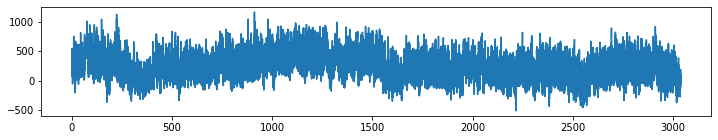

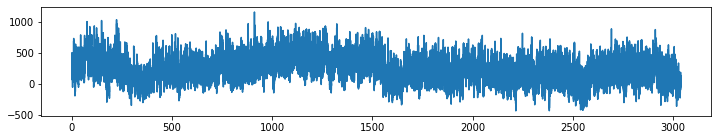

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0   0.0735  0.1237  0.0994  0.1742  0.2503  0.3183  0.1573  0.2879  0.5006   
5   0.1457  0.1656  0.1828  0.2601  0.3164  0.3641  0.2191  0.3949  0.5327   
10  0.1185  0.1493  0.1595  0.2403  0.3054  0.3582  0.2009  0.3717  0.5351   
15  0.0860  0.1121  0.1190  0.2455  0.2710  0.3648  0.1808  0.3690  0.5470   
20  0.1291  0.1233  0.1741  0.2807  0.3315  0.4040  0.2601  0.3291  0.5303   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0  -0.0788  ...  0.1796  0.5639  0.3937  0.1608  0.0488  0.1551  0.6254   
5  -0.0657  ...  0.2896  0.6310  0.4622  0.2111  0.2037  0.1364  0.6286   
10 -0.0618  ...  0.2059  0.6270  0.4980  0.2613  0.1959  0.2517  0.6960   
15 -0.0460  ...  0.2116  0.5982  0.4335  0.2151  0.1322  0.1144  0.6532   
20 -0.0184  ...  0.1616  0.5599  0.4294  0.2322  0.1293  0.2136  0.6190   

        Oz      O2    PO10  
0  -0.2723  0.1879  0.2133  
5  -0.3275  0.1167  0.0033  
10 -0.2122  0.2770  0.1944  
15 -0.2364  0.2372  0.2472  
20 -0.2426  0.2315  0.2166  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



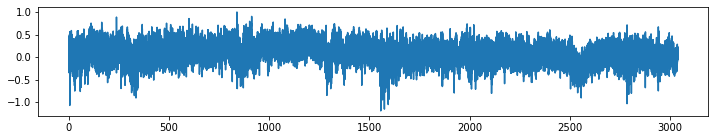



Channel 6 [After Low-Pass] -



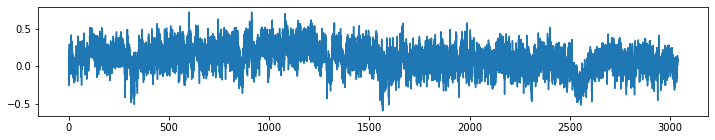



Channel 6 [Before vs After] -



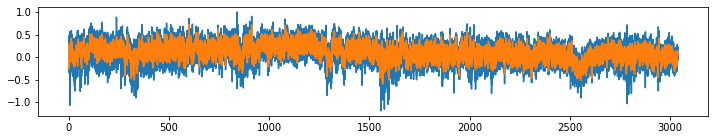

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0 -0.000896  0.000927  0.004809  0.000760 -0.000293 -0.000983 -0.000230   
1 -0.000920  0.000891  0.004642  0.000687 -0.000598 -0.001472 -0.000077   
2 -0.000941  0.000857  0.004482  0.000615 -0.000890 -0.001926  0.000059   
3 -0.000957  0.000825  0.004336  0.000547 -0.001158 -0.002321  0.000170   

         8         9         10  ...        23        24        25        26  \
0  0.001506  0.001929  0.001850  ... -0.001947  0.000647 -0.003224 -0.002325   
1  0.001421  0.001530  0.001890  ... -0.001593  0.000477 -0.003188 -0.001814   
2  0.001348  0.001152  0.001927  ... -0.001253  0.000315 -0.003160 -0.001344   
3  0.001295  0.000809  0.001956  ... -0.000930  0.000163 -0.003143 -0.000938   

         27        28        29        30        31        32  
0 -0.003514 -0.002183  0.000103 -0.001601  0.002197  0.001405  
1 -0.003460 -0.002018 -0.000011 -0.001955  0.002117  0.001247  
2 -0.003391 -0.001859 -0.000121 -0.002297  0.002041  0.001101  
3 -0.003305 -0.001714 -0.000224 -0.002615  0.001972  0.000975  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0 -0.572440  0.831440 -0.446280  0.371451 -0.257794  0.358739  0.226193   
1 -0.579364  0.841442 -0.416482  0.366599 -0.273849  0.349727  0.226895   
2 -0.582013  0.851738 -0.387682  0.362331 -0.289318  0.340118  0.227057   
3 -0.577428  0.862353 -0.361040  0.358953 -0.303688  0.329829  0.226463   

          8  
0 -0.017570  
1 -0.035618  
2 -0.053055  
3 -0.069361

###Visualization

####Signals [Dimensions Reduced]

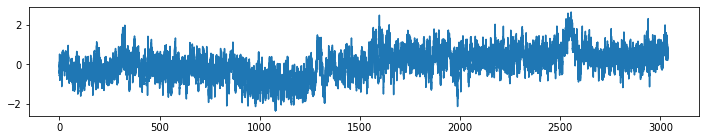

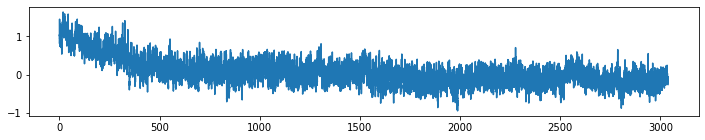

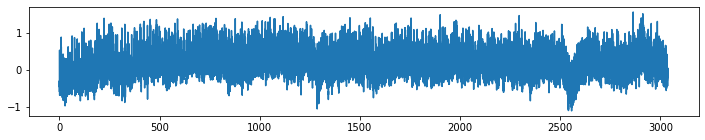

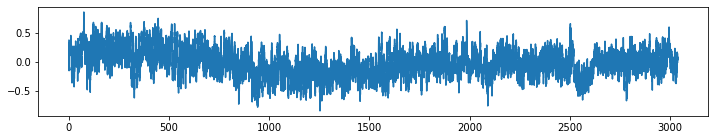

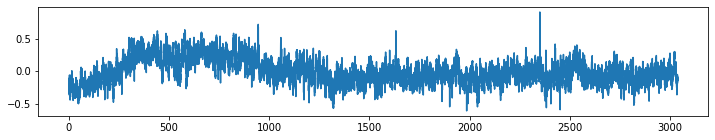

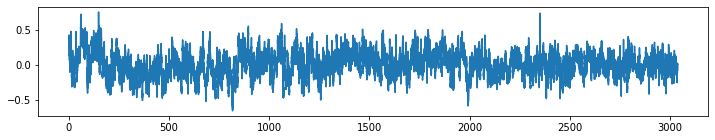

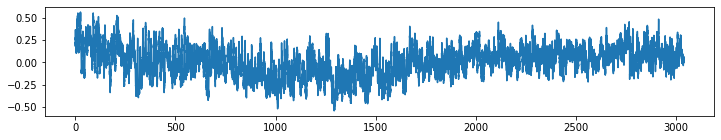

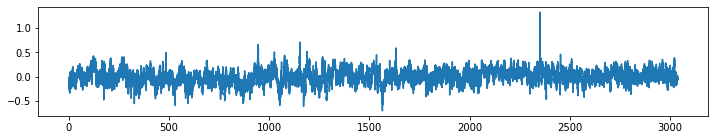

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

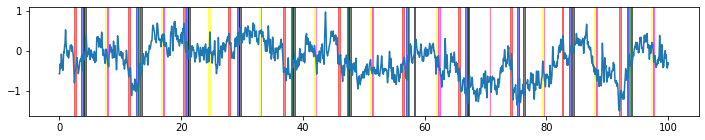

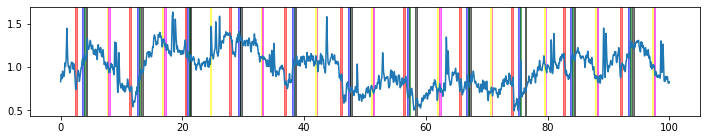

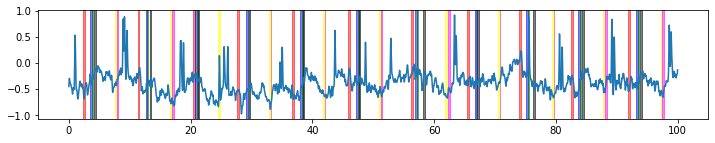

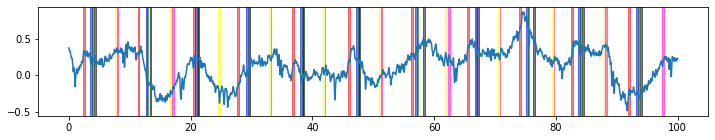

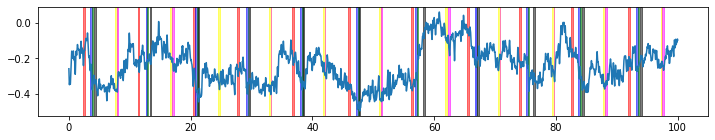

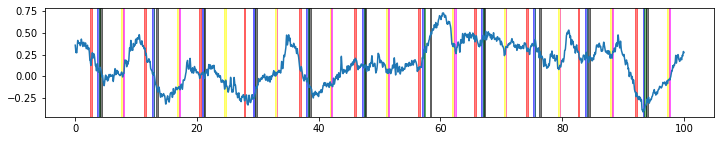

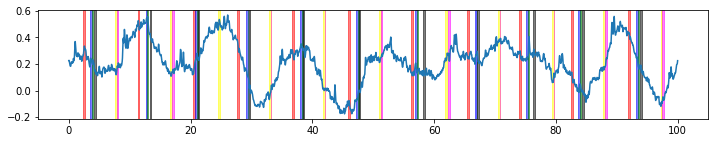

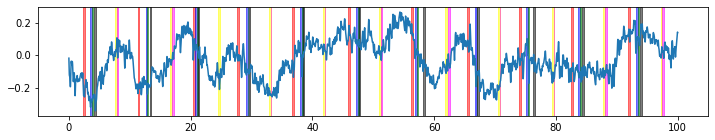

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (250037, 32)
x train : (250037, 6)
x val   : (53847, 32)
y val   : (53847, 6)


In [ ]:
x_train.to_csv(path+'x_train6.csv',index=False)
y_train.to_csv(path+'y_train6.csv',index=False)
x_val.to_csv(path+'x_val6.csv',index=False)
y_val.to_csv(path+'y_val6.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train6.csv')
y_train = pd.read_csv(path+'y_train6.csv')
x_val = pd.read_csv(path+'x_val6.csv')
y_val = pd.read_csv(path+'y_val6.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (250037, 32)
y train : (250037, 6)
x val   : (53847, 32)
y val   : (53847, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5726127743355145
0.607241895542165
0.6310549486650492
0.6996368875884363
0.7133359221272619
0.700296064919685

0.6540297488630187


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5744271914954335
0.6092174310610611
0.6293382878080296
0.6466838221574267
0.7304758479530171
0.7282487376791008

0.6530652196923449


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.6807455045252799
0.6683467901415396
0.696786735231858
0.7329471148005209
0.8720403253856603
0.8373490769095098

0.7480359244990614


In [ ]:
probs1

array([[0.01298666, 0.00265331, 0.00239051, 0.00205603, 0.00268174,
        0.00447467],
       [0.01223815, 0.00293446, 0.00282824, 0.00291126, 0.00367501,
        0.00539275],
       [0.01138283, 0.00321001, 0.00329124, 0.00406453, 0.00506348,
        0.00648696],
       ...,
       [0.01254922, 0.01140311, 0.00973282, 0.0166552 , 0.01327066,
        0.00997496],
       [0.01671194, 0.01378279, 0.01166001, 0.020418  , 0.01258339,
        0.00943093],
       [0.02266384, 0.01688782, 0.01419605, 0.02548616, 0.01202534,
        0.00896395]])

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.6618583036511456
0.6730340778386749
0.6983344479529415
0.7407645628174254
0.8581246307467725
0.8241765250891602

0.7427154246826867


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.6678775759729645
0.6916941867951071
0.7019167956332648
0.742713926538052
0.857305867895057
0.8380108988602872

0.7499198752824553


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.6638603232131928
0.6698499228092805
0.6929896576925596
0.7193466597556466
0.8329917374327112
0.7853784521510266

0.7274027921757362


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
7814/7814 [==============================] - 15s 2ms/step - loss: 1.4621 - accuracy: 0.1621
Epoch 2/5
7814/7814 [==============================] - 15s 2ms/step - loss: 0.3447 - accuracy: 0.1752
Epoch 3/5
7814/7814 [==============================] - 15s 2ms/step - loss: 0.4083 - accuracy: 0.1735
Epoch 4/5
7814/7814 [==============================] - 15s 2ms/step - loss: 0.5652 - accuracy: 0.1651
Epoch 5/5
7814/7814 [==============================] - 15s 2ms/step - loss: 0.7405 - accuracy: 0.1664


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
489/489 [==============================] - 2s 2ms/step - loss: 0.2728 - accuracy: 0.9677
Epoch 2/5
489/489 [==============================] - 1s 2ms/step - loss: 0.1579 - accuracy: 0.9770
Epoch 3/5
489/489 [==============================] - 1s 2ms/step - loss: 0.1364 - accuracy: 0.9770
Epoch 4/5
489/489 [==============================] - 1s 2ms/step - loss: 0.1256 - accuracy: 0.9770
Epoch 5/5
489/489 [==============================] - 1s 2ms/step - loss: 0.1199 - accuracy: 0.9770
0.6768469284754842
Epoch 1/5
489/489 [==============================] - 1s 2ms/step - loss: 0.3034 - accuracy: 0.9544
Epoch 2/5
489/489 [==============================] - 1s 2ms/step - loss: 0.1597 - accuracy: 0.9770
Epoch 3/5
489/489 [==============================] - 1s 2ms/step - loss: 0.1430 - accuracy: 0.9770
Epoch 4/5
489/489 [==============================] - 1s 2ms/step - loss: 0.1334 - accuracy: 0.9770
Epoch 5/5
489/489 [==============================] - 1s 2ms/step - loss: 0.1262 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5258248327029772
0.517140990296943
0.52757443539502
0.5282040109652832
0.5468443065646742
0.5476377350021213

0.5322043851545032


# Subject 7

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj7_data.csv')
train_events = pd.read_csv(path+'Train/subj7_events.csv')
val_data = pd.read_csv(path+'Validation/subj7_data.csv')
val_events = pd.read_csv(path+'Validation/subj7_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1367619, 32)
Train Events      : (1367619, 6)
Validation Data   : (285321, 32)
Validation Events : (285321, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1367619


In [ ]:
x.head(4)

Fp1  Fp2    F7   F3   Fz   F4   F8  FC5  FC1  FC2  ...   P7   P3   Pz   P4  \
0  -54 -523  2571  250 -369 -276 -764  666  -14  -56  ...  701  265  174  183   
1  -59 -548  2582  241 -374 -288 -817  629  -27  -81  ...  703  293  178  169   
2 -133 -550  2586  244 -407 -344 -849  632  -21 -107  ...  689  288  169  137   
3 -176 -525  2578  319 -373 -339 -807  612   10  -61  ...  709  310  193  149   

    P8  PO9   O1   Oz   O2  PO10  
0  467  335  393  100  181    91  
1  437  319  387   85  144    50  
2  384  293  412   70  106    -1  
3  337  294  462  167  155    21  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

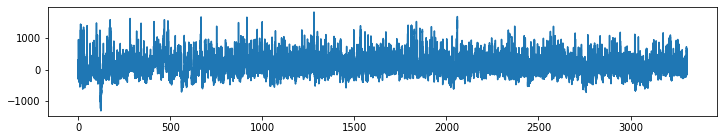

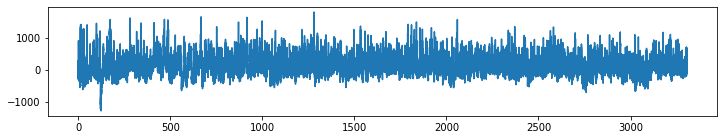

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0  -0.0102 -0.1156  0.7304  0.1390 -0.3686 -0.1981 -0.5442  0.4599 -0.0553   
5  -0.0671 -0.1528  0.6938  0.1452 -0.4136 -0.4171 -0.7400  0.4130 -0.0356   
10 -0.0741 -0.1616  0.6250  0.0634 -0.4695 -0.2096 -0.5385  0.3094 -0.1344   
15 -0.0300 -0.1386  0.6216  0.1073 -0.3626 -0.1508 -0.3568  0.3384 -0.0949   
20 -0.0756 -0.0984  0.5062  0.0234 -0.4216 -0.1400 -0.2635  0.1996 -0.3715   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0  -0.1628  ...  0.5590  0.2789  0.1977  0.1805  0.3866  0.2068  0.3119   
5  -0.3692  ...  0.4952  0.3589  0.2080  0.1321  0.2939  0.0623  0.3397   
10 -0.1919  ...  0.5646  0.4126  0.2807  0.1716  0.2748  0.1389  0.4254   
15 -0.1308  ...  0.4968  0.3768  0.2580  0.2120  0.3270  0.1340  0.4167   
20 -0.1047  ...  0.5351  0.3758  0.2841  0.2574  0.4363  0.1802  0.4087   

        Oz      O2    PO10  
0   0.0881  0.1609  0.0861  
5   0.0872  0.1129 -0.0047  
10  0.1559  0.0960 -0.0747  
15  0.1322  0.1191 -0.0445  
20  0.1612  0.1698  0.0492  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



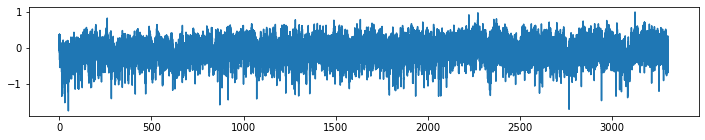



Channel 6 [After Low-Pass] -



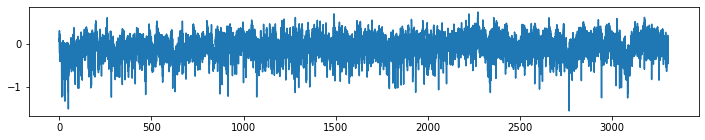



Channel 6 [Before vs After] -



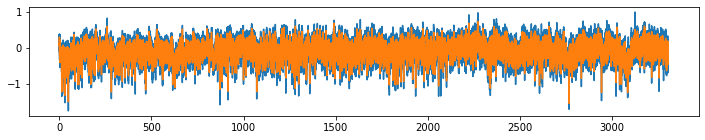

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0  0.001461 -0.002286 -0.000010  0.003148  0.001253  0.003825  0.011239   
1  0.001431 -0.002122 -0.000257  0.002808  0.001400  0.003406  0.009965   
2  0.001397 -0.001976 -0.000496  0.002490  0.001544  0.002994  0.008694   
3  0.001354 -0.001854 -0.000725  0.002209  0.001682  0.002594  0.007436   

         8         9         10  ...        23        24        25        26  \
0  0.000325  0.001277 -0.000511  ... -0.003790 -0.005823  0.000187  0.002996   
1  0.000230  0.000976 -0.000499  ... -0.003841 -0.005046 -0.000107  0.003104   
2  0.000152  0.000700 -0.000480  ... -0.003886 -0.004282 -0.000375  0.003189   
3  0.000101  0.000463 -0.000448  ... -0.003922 -0.003544 -0.000600  0.003245   

         27        28        29        30        31        32  
0 -0.010553 -0.003175 -0.005234 -0.000091  0.001232 -0.003447  
1 -0.010524 -0.002798 -0.004971 -0.000056  0.001203 -0.003198  
2 -0.010479 -0.002425 -0.004709 -0.000019  0.001177 -0.002986  
3 -0.010404 -0.002054 -0.004449  0.000022  0.001156 -0.002826  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0 -0.913737  0.220123 -0.443643  0.575820 -0.097838  0.534837 -0.760705   
1 -0.942834  0.122932 -0.396135  0.517365 -0.080778  0.483753 -0.711596   
2 -0.973612  0.026681 -0.345636  0.457172 -0.062831  0.430932 -0.663768   
3 -1.005406 -0.067497 -0.292358  0.395136 -0.043875  0.375830 -0.618072   

          8  
0  0.174959  
1  0.162208  
2  0.148039  
3  0.132087

###Visualization

####Signals [Dimensions Reduced]

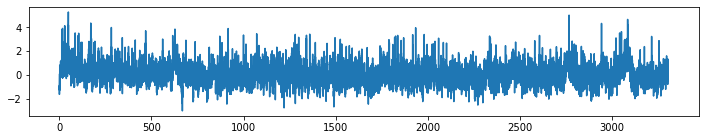

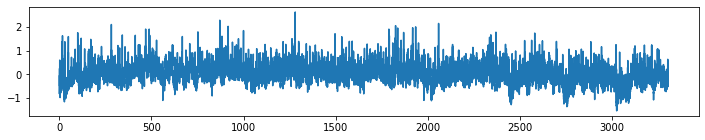

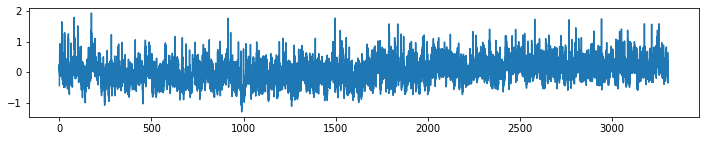

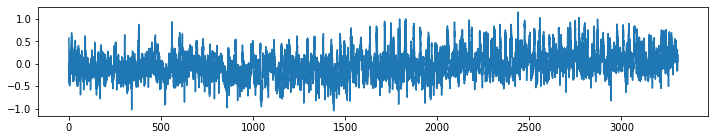

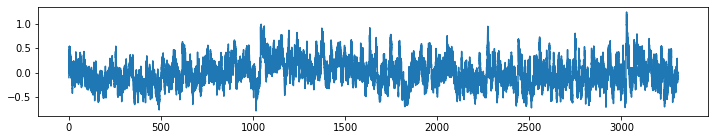

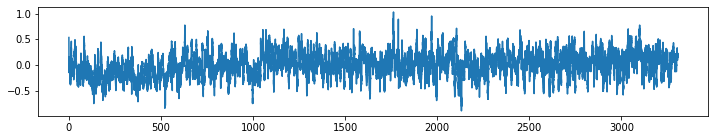

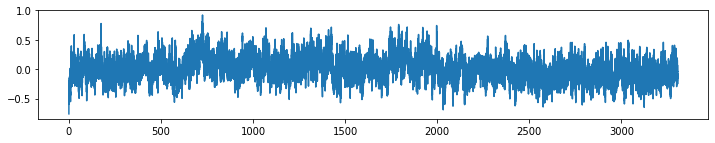

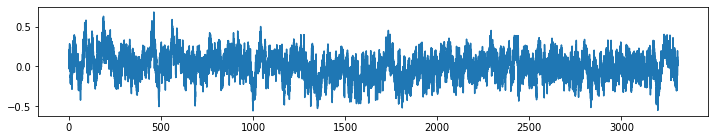

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

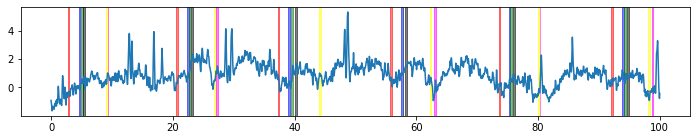

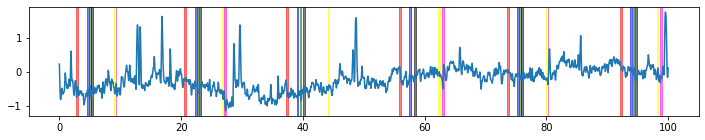

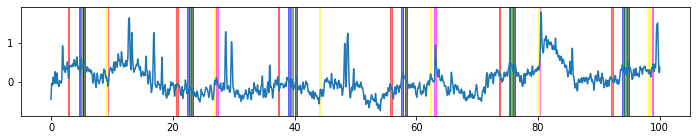

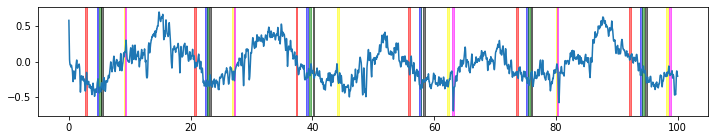

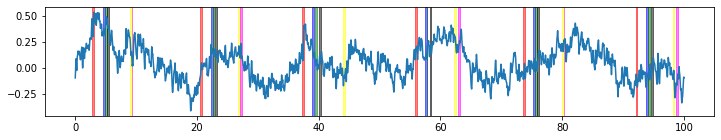

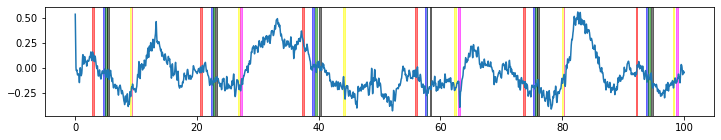

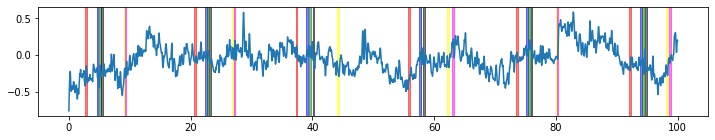

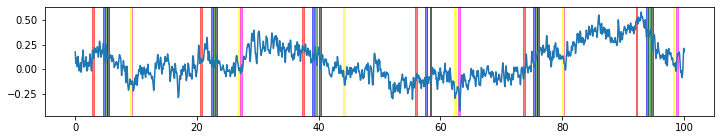

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (273523, 32)
x train : (273523, 6)
x val   : (57065, 32)
y val   : (57065, 6)


In [ ]:
x_train.to_csv(path+'x_train7.csv',index=False)
y_train.to_csv(path+'y_train7.csv',index=False)
x_val.to_csv(path+'x_val7.csv',index=False)
y_val.to_csv(path+'y_val7.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train7.csv')
y_train = pd.read_csv(path+'y_train7.csv')
x_val = pd.read_csv(path+'x_val7.csv')
y_val = pd.read_csv(path+'y_val7.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (273523, 32)
y train : (273523, 6)
x val   : (57065, 32)
y val   : (57065, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7734135642444165
0.7255565206546044
0.7360961880150845
0.7141725686185424
0.6828136141326135
0.7255934735548012

0.726274321536677


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7699441920339241
0.699165419461742
0.7068999796996482
0.6833209949131857
0.6800733980098173
0.599073393555514

0.6897462296123053


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.8280723467942379
0.7666288318144159
0.7547270913989793
0.7604726372148132
0.706492164880491
0.7580419149940758

0.7624058311828356


In [ ]:
probs1

array([[0.01015969, 0.00314852, 0.00360792, 0.00161892, 0.01194684,
        0.00930888],
       [0.01024085, 0.00453803, 0.00515617, 0.00229946, 0.01717489,
        0.01282471],
       [0.01019498, 0.0063847 , 0.00717244, 0.00321045, 0.02394141,
        0.01721967],
       ...,
       [0.00211551, 0.00188592, 0.00172615, 0.00503044, 0.00326686,
        0.00177772],
       [0.00232927, 0.00217074, 0.00176157, 0.00660192, 0.00369445,
        0.00177684],
       [0.00256465, 0.00253156, 0.00181178, 0.00878551, 0.00426639,
        0.00180135]])

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.820249993318545
0.7725524939644189
0.7595729974383395
0.767315623023403
0.7046753080150734
0.7664977862112587

0.7651440336618398


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.8043285315943732
0.786081803280149
0.8036150589612903
0.8112272674630961
0.7862066128586828
0.7527913292531916

0.7907084339017972


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.7910517456414643
0.7801813925933845
0.7884842986224685
0.7851785462935743
0.7823498409813722
0.7638812215481376

0.7818545076134003


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
8548/8548 [==============================] - 14s 2ms/step - loss: 1.0596 - accuracy: 0.1718
Epoch 2/5
8548/8548 [==============================] - 14s 2ms/step - loss: 0.3977 - accuracy: 0.1772
Epoch 3/5
8548/8548 [==============================] - 14s 2ms/step - loss: 0.2530 - accuracy: 0.1881
Epoch 4/5
8548/8548 [==============================] - 14s 2ms/step - loss: 0.2572 - accuracy: 0.1928
Epoch 5/5
8548/8548 [==============================] - 14s 2ms/step - loss: 0.2962 - accuracy: 0.1797


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
535/535 [==============================] - 1s 2ms/step - loss: 0.3005 - accuracy: 0.9759
Epoch 2/5
535/535 [==============================] - 1s 2ms/step - loss: 0.1295 - accuracy: 0.9789
Epoch 3/5
535/535 [==============================] - 1s 2ms/step - loss: 0.1181 - accuracy: 0.9789
Epoch 4/5
535/535 [==============================] - 1s 2ms/step - loss: 0.1123 - accuracy: 0.9789
Epoch 5/5
535/535 [==============================] - 1s 2ms/step - loss: 0.1083 - accuracy: 0.9789
0.7962706523772617
Epoch 1/5
535/535 [==============================] - 1s 2ms/step - loss: 0.2686 - accuracy: 0.9616
Epoch 2/5
535/535 [==============================] - 1s 2ms/step - loss: 0.1303 - accuracy: 0.9789
Epoch 3/5
535/535 [==============================] - 1s 2ms/step - loss: 0.1195 - accuracy: 0.9789
Epoch 4/5
535/535 [==============================] - 1s 2ms/step - loss: 0.1124 - accuracy: 0.9789
Epoch 5/5
535/535 [==============================] - 1s 2ms/step - loss: 0.1077 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.6062063144203615
0.5588862549108694
0.5501286987565778
0.5709306732234012
0.6221567647504254
0.5970152916232372

0.5842206662808122


# Subject 8

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj8_data.csv')
train_events = pd.read_csv(path+'Train/subj8_events.csv')
val_data = pd.read_csv(path+'Validation/subj8_data.csv')
val_events = pd.read_csv(path+'Validation/subj8_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1116358, 32)
Train Events      : (1116358, 6)
Validation Data   : (242709, 32)
Validation Events : (242709, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1116358


In [ ]:
x.head(4)

Fp1  Fp2   F7   F3  Fz   F4   F8  FC5  FC1  FC2  ...   P7   P3   Pz   P4  \
0  -11 -108  440  210  81  312 -467  192  270  132  ...  367  217  191   98   
1   18  -73  469  212  65  331 -433  195  264  149  ...  347  209  181  104   
2   16  -66  456  184  87  338 -417  197  253  136  ...  355  199  198  117   
3   23  -83  453  191  90  337 -421  189  272  145  ...  380  219  199  143   

    P8  PO9   O1  Oz   O2  PO10  
0  264 -146  -54  48 -116  -410  
1  254 -248 -116   7 -145  -471  
2  306 -216  -81  77 -104  -272  
3  342 -187  -50  66  -78  -138  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

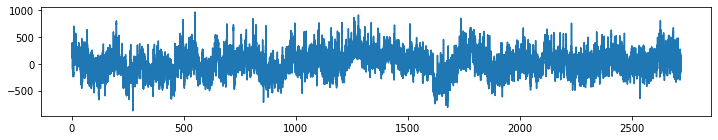

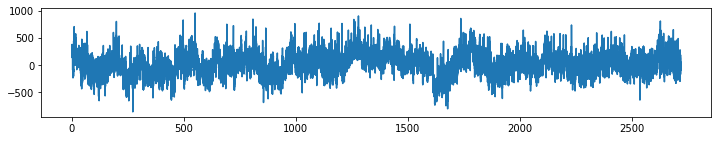

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0  -0.0040 -0.0317  0.2116  0.2201  0.1366  0.2977 -0.3044  0.1749  0.5047   
5   0.0069 -0.0223  0.2145  0.2296  0.1703  0.3616 -0.2425  0.1958  0.4860   
10  0.0088 -0.0129  0.2347  0.2495  0.1686  0.3569 -0.2243  0.2322  0.5439   
15  0.0208 -0.0100  0.2617  0.2830  0.1686  0.3597 -0.1949  0.2413  0.5720   
20  0.0120 -0.0185  0.2626  0.2736  0.1535  0.3473 -0.2379  0.2495  0.5850   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0   0.2422  ...  0.3164  0.2024  0.1831  0.1043  0.1851 -0.1106 -0.0390   
5   0.2606  ...  0.3336  0.2071  0.1927  0.1160  0.2153 -0.1394 -0.0462   
10  0.2991  ...  0.4017  0.2789  0.2819  0.2702  0.3156 -0.0705  0.0245   
15  0.3101  ...  0.4655  0.2640  0.2617  0.2511  0.3107  0.0038  0.0267   
20  0.3229  ...  0.4009  0.2136  0.2359  0.2596  0.3107 -0.0720  0.0267   

        Oz      O2    PO10  
0   0.0416 -0.0983 -0.2737  
5   0.0078 -0.1144 -0.2850  
10  0.1362  0.0271 -0.0768  
15  0.0494 -0.0771 -0.1996  
20  0.1440  0.0246 -0.0968  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



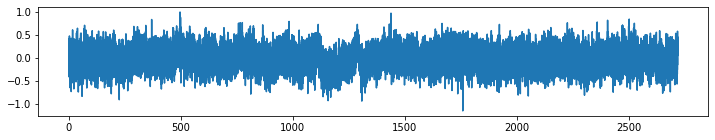



Channel 6 [After Low-Pass] -



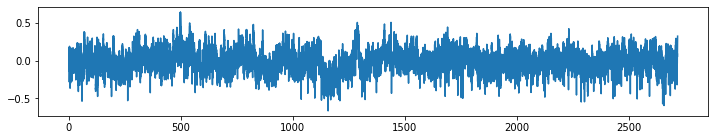



Channel 6 [Before vs After] -



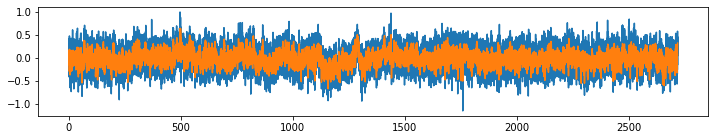

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0 -0.000138  0.000850  0.000224  0.003740  0.002602  0.000480  0.002496   
1 -0.000402  0.000972  0.000201  0.003548  0.002538  0.000407  0.002378   
2 -0.000641  0.001089  0.000172  0.003362  0.002467  0.000343  0.002270   
3 -0.000839  0.001196  0.000128  0.003189  0.002384  0.000292  0.002181   

         8         9         10  ...        23        24        25        26  \
0  0.003460 -0.001299  0.000353  ...  0.000100  0.004679 -0.000130  0.005121   
1  0.003604 -0.001264  0.000396  ...  0.000135  0.004538  0.000050  0.004806   
2  0.003735 -0.001225  0.000447  ...  0.000173  0.004405  0.000226  0.004510   
3  0.003839 -0.001178  0.000506  ...  0.000212  0.004284  0.000392  0.004253   

         27        28        29        30        31        32  
0  0.001825  0.003515  0.002674  0.000919  0.002873 -0.000589  
1  0.001789  0.003406  0.002728  0.000667  0.002946 -0.000492  
2  0.001754  0.003290  0.002784  0.000421  0.003016 -0.000394  
3  0.001717  0.003160  0.002842  0.000189  0.003079 -0.000297  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0  0.037586  0.161850 -0.438830  0.157046  0.264753  0.330859 -0.202993   
1  0.121233  0.147615 -0.423830  0.140958  0.273821  0.315284 -0.193097   
2  0.199835  0.132927 -0.409676  0.125051  0.281679  0.300902 -0.183933   
3  0.268582  0.118374 -0.397218  0.109712  0.287623  0.288517 -0.176132   

          8  
0  0.003727  
1  0.009024  
2  0.013903  
3  0.017721

###Visualization

####Signals [Dimensions Reduced]

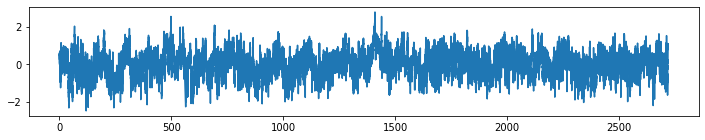

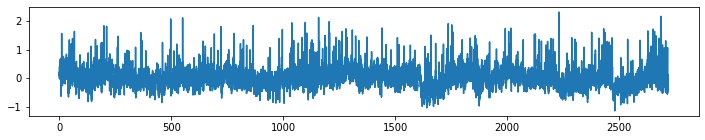

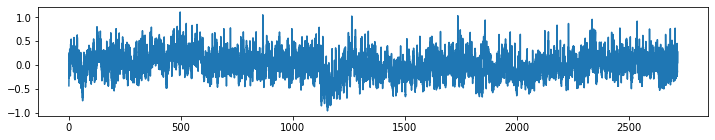

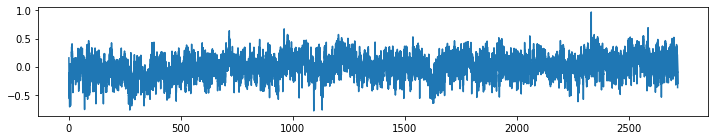

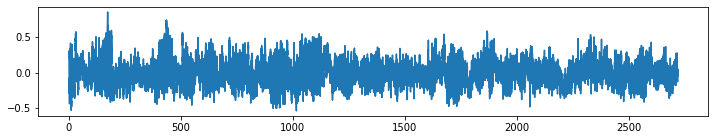

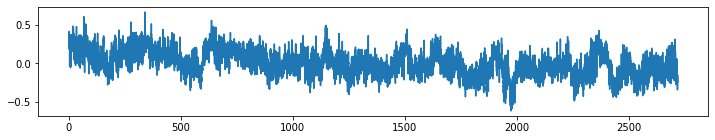

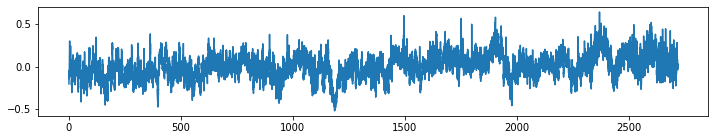

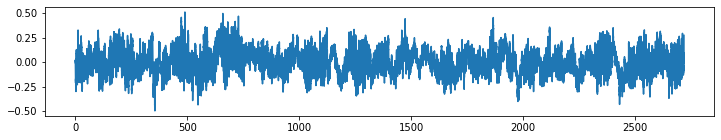

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

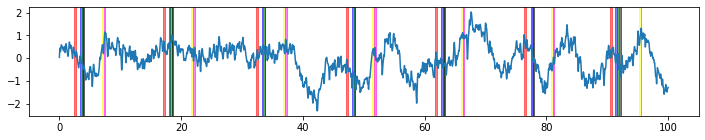

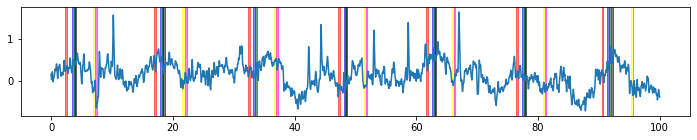

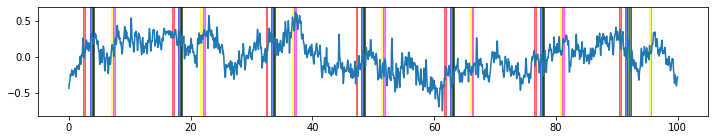

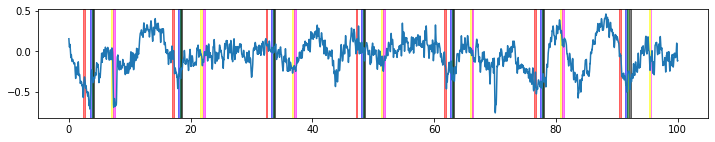

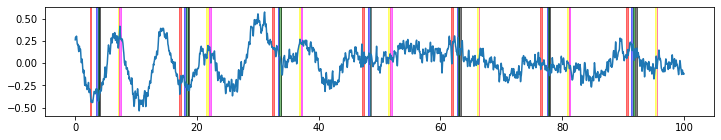

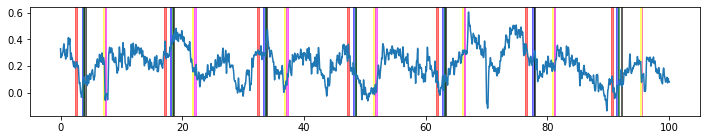

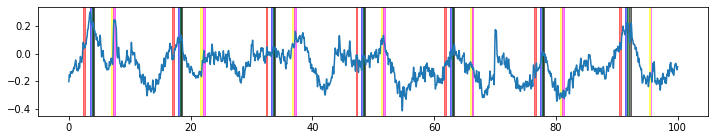

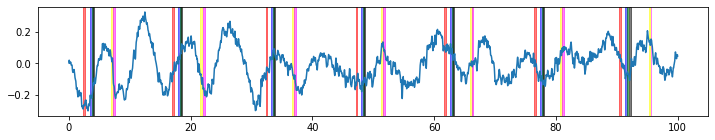

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (223271, 32)
x train : (223271, 6)
x val   : (48543, 32)
y val   : (48543, 6)


In [ ]:
x_train.to_csv(path+'x_train8.csv',index=False)
y_train.to_csv(path+'y_train8.csv',index=False)
x_val.to_csv(path+'x_val8.csv',index=False)
y_val.to_csv(path+'y_val8.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train8.csv')
y_train = pd.read_csv(path+'y_train8.csv')
x_val = pd.read_csv(path+'x_val8.csv')
y_val = pd.read_csv(path+'y_val8.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (223271, 32)
y train : (223271, 6)
x val   : (48543, 32)
y val   : (48543, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.570505550348217
0.6707235523071884
0.6742176975299506
0.6640076878868872
0.5675898308057713
0.6474218192964991

0.6324110230290856


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5546241693030136
0.6530657256774073
0.6636555969612755
0.6300057965899734
0.5546926974561625
0.5256752305248702

0.596953202752117


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.6302427884686336
0.7253030481271923
0.7592198669029575
0.7753853219674212
0.694110963956363
0.7092526499449961

0.7155857732279273


In [ ]:
probs1

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7462330147023881
0.6822828275930645
0.7093980754355467
0.7351855379328164
0.6413449907773134
0.6923002047400497

0.7011241085301965


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.5994943558353604
0.69889767811733
0.7222652143884456
0.7111524325017192
0.7376137550476397
0.7380222465090804

0.7012409470665958


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.5941757552643663
0.6767843620040537
0.7158932451332467
0.7052059101816328
0.7176875527322083
0.7312332000086016

0.6901633375540182


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
6978/6978 [==============================] - 12s 2ms/step - loss: 1.0676 - accuracy: 0.1850
Epoch 2/5
6978/6978 [==============================] - 12s 2ms/step - loss: 0.4337 - accuracy: 0.1922
Epoch 3/5
6978/6978 [==============================] - 11s 2ms/step - loss: 0.3144 - accuracy: 0.2108
Epoch 4/5
6978/6978 [==============================] - 11s 2ms/step - loss: 0.3257 - accuracy: 0.2049
Epoch 5/5
6978/6978 [==============================] - 11s 2ms/step - loss: 0.3643 - accuracy: 0.1931


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
437/437 [==============================] - 1s 2ms/step - loss: 0.3470 - accuracy: 0.9503
Epoch 2/5
437/437 [==============================] - 1s 2ms/step - loss: 0.1593 - accuracy: 0.9742
Epoch 3/5
437/437 [==============================] - 1s 2ms/step - loss: 0.1485 - accuracy: 0.9742
Epoch 4/5
437/437 [==============================] - 1s 2ms/step - loss: 0.1448 - accuracy: 0.9742
Epoch 5/5
437/437 [==============================] - 1s 2ms/step - loss: 0.1408 - accuracy: 0.9742
0.5675003520751138
Epoch 1/5
437/437 [==============================] - 1s 2ms/step - loss: 0.3548 - accuracy: 0.9579
Epoch 2/5
437/437 [==============================] - 1s 2ms/step - loss: 0.1592 - accuracy: 0.9742
Epoch 3/5
437/437 [==============================] - 1s 2ms/step - loss: 0.1465 - accuracy: 0.9742
Epoch 4/5
437/437 [==============================] - 1s 2ms/step - loss: 0.1403 - accuracy: 0.9742
Epoch 5/5
437/437 [==============================] - 1s 2ms/step - loss: 0.1359 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5136768163386464
0.5019117889505758
0.5339568225199891
0.5556841683838235
0.5627060535415593
0.588282202328924

0.5427029753439196


# Subject 9

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj9_data.csv')
train_events = pd.read_csv(path+'Train/subj9_events.csv')
val_data = pd.read_csv(path+'Validation/subj9_data.csv')
val_events = pd.read_csv(path+'Validation/subj9_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1191790, 32)
Train Events      : (1191790, 6)
Validation Data   : (255704, 32)
Validation Events : (255704, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1191790


In [ ]:
x.head(4)

Fp1  Fp2    F7    F3   Fz   F4  F8  FC5  FC1  FC2  ...   P7  P3   Pz  P4  \
0 -745  552 -1261 -1499  -89  325  50 -155 -265 -343  ...  359  27  130  35   
1 -796  585 -1295 -1498  -95  308  30 -159 -272 -348  ...  339  29  122  32   
2 -749  602 -1243 -1501 -101  295  24 -156 -274 -353  ...  361  29  115  38   
3 -698  617 -1225 -1527  -73  320  27 -148 -281 -338  ...  375  41  147  56   

     P8  PO9   O1   Oz   O2  PO10  
0 -1139   26  233 -128   89   -46  
1 -1181   69  241  -92  169    -2  
2 -1160   59  253  -60  186    92  
3 -1113   94  277  -23  224    71  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

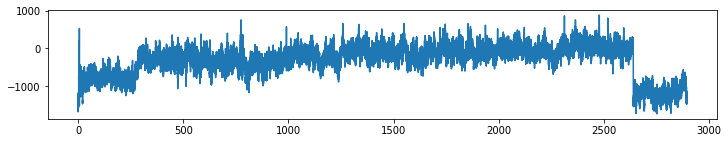

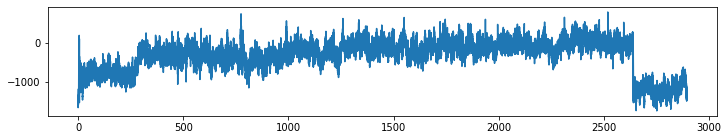

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0  -0.0392  0.0339 -0.6190 -1.8621 -0.0977  0.2420  0.0322 -0.1109 -0.2629   
5  -0.0407  0.0365 -0.6019 -1.8845 -0.1405  0.2107  0.0180 -0.1209 -0.2718   
10 -0.0425  0.0376 -0.6132 -1.8435 -0.0746  0.2547  0.0154 -0.1330 -0.2639   
15 -0.0424  0.0378 -0.6220 -1.8720 -0.0999  0.2427  0.0142 -0.1559 -0.3165   
20 -0.0454  0.0367 -0.6210 -1.8795 -0.0977  0.2539  0.0193 -0.1080 -0.2927   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0  -0.2616  ...  0.2117  0.0206  0.0948  0.0284 -0.7411  0.0129  0.1448   
5  -0.2708  ...  0.2070  0.0076  0.0627  0.0219 -0.7189  0.0441  0.1548   
10 -0.2387  ...  0.1828 -0.0244  0.0394 -0.0438 -0.7612  0.0466  0.1641   
15 -0.2616  ...  0.1675 -0.0373  0.0160 -0.0389 -0.7697  0.0461  0.1249   
20 -0.2418  ...  0.1846 -0.0411  0.0182 -0.0421 -0.7996  0.0743  0.1492   

        Oz      O2    PO10  
0  -0.0970  0.0621 -0.0212  
5  -0.0508  0.1305 -0.0083  
10 -0.0796  0.0579  0.0161  
15 -0.1054  0.0426  0.0189  
20 -0.1039  0.0642 -0.0180  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



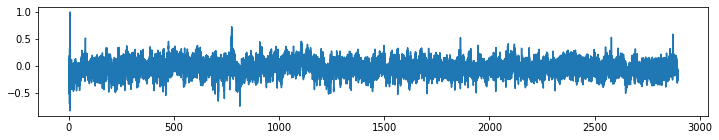



Channel 6 [After Low-Pass] -



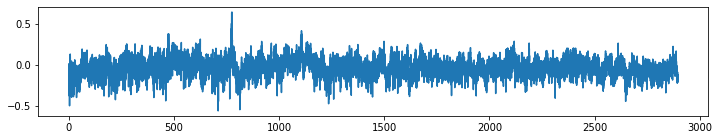



Channel 6 [Before vs After] -



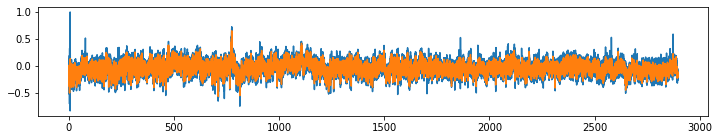

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0  0.001449 -0.002374  0.001858 -0.001376  0.001504  0.000099 -0.002800   
1  0.001288 -0.002422  0.001907 -0.001064  0.001560  0.000167 -0.002874   
2  0.001140 -0.002467  0.001946 -0.000774  0.001619  0.000234 -0.002940   
3  0.001013 -0.002506  0.001976 -0.000520  0.001681  0.000305 -0.002987   

         8         9         10  ...        23        24        25        26  \
0 -0.001232 -0.000683  0.007122  ... -0.003964 -0.000018 -0.001246  0.001987   
1 -0.000974 -0.000723  0.007383  ... -0.003712  0.000185 -0.001397  0.001923   
2 -0.000739 -0.000764  0.007621  ... -0.003484  0.000375 -0.001534  0.001870   
3 -0.000544 -0.000807  0.007824  ... -0.003295  0.000543 -0.001642  0.001832   

         27        28        29        30        31        32  
0  0.005161  0.003662  0.000063  0.001902  0.001202 -0.002536  
1  0.005134  0.003510 -0.000113  0.001573  0.001262 -0.002495  
2  0.005112  0.003370 -0.000282  0.001260  0.001316 -0.002458  
3  0.005100  0.003248 -0.000440  0.000976  0.001356 -0.002433  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0 -1.575763  0.829287 -0.117636  0.124935 -0.151779  0.448468  0.116863   
1 -1.611427  0.811571 -0.128520  0.129220 -0.153272  0.448749  0.119652   
2 -1.646640  0.794527 -0.139389  0.132367 -0.154256  0.449011  0.122740   
3 -1.680996  0.778839 -0.150467  0.133577 -0.154396  0.449475  0.125996   

          8  
0  1.051648  
1  1.046889  
2  1.042840  
3  1.039736

###Visualization

####Signals [Dimensions Reduced]

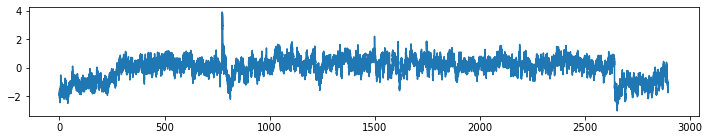

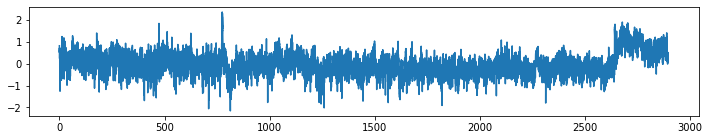

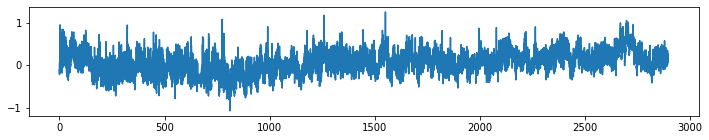

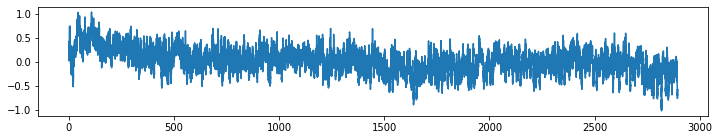

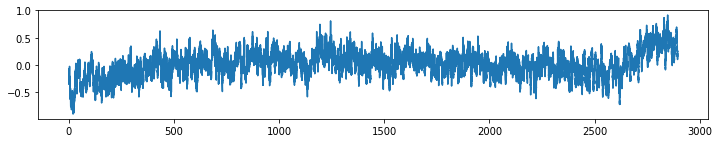

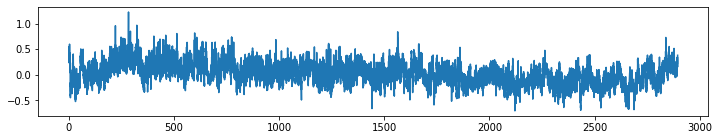

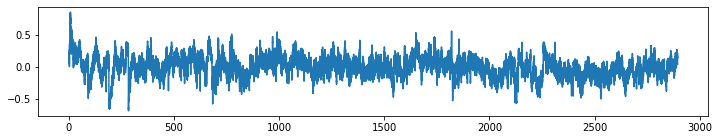

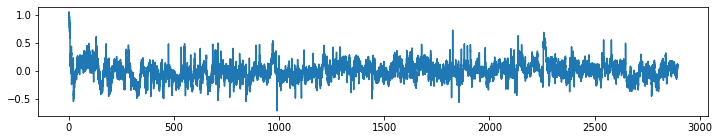

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

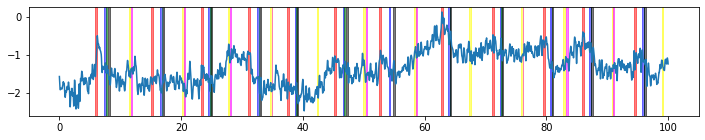

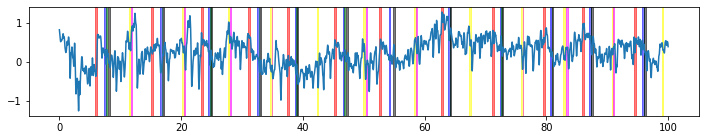

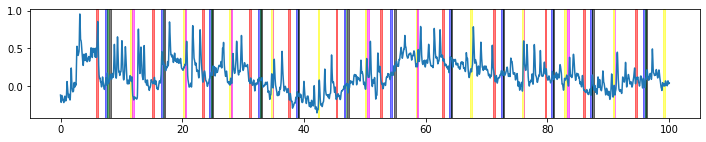

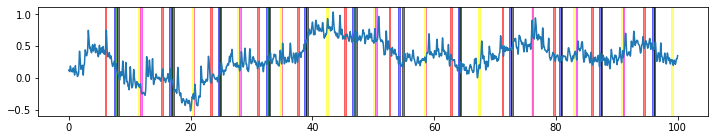

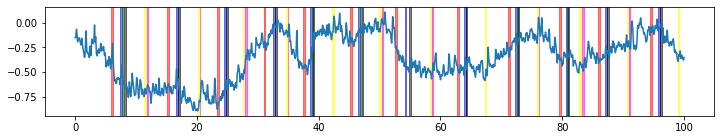

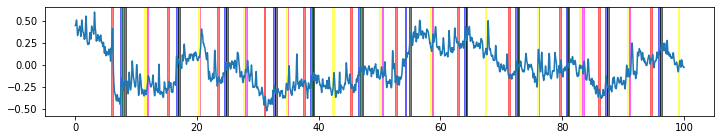

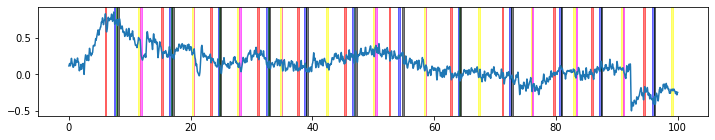

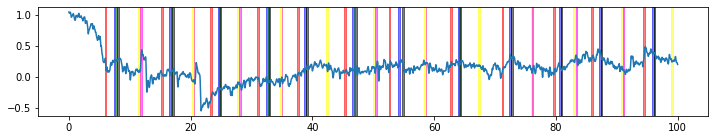

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (238358, 32)
x train : (238358, 6)
x val   : (51141, 32)
y val   : (51141, 6)


In [ ]:
x_train.to_csv(path+'x_train9.csv',index=False)
y_train.to_csv(path+'y_train9.csv',index=False)
x_val.to_csv(path+'x_val9.csv',index=False)
y_val.to_csv(path+'y_val9.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train9.csv')
y_train = pd.read_csv(path+'y_train9.csv')
x_val = pd.read_csv(path+'x_val9.csv')
y_val = pd.read_csv(path+'y_val9.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (238358, 32)
y train : (238358, 6)
x val   : (51141, 32)
y val   : (51141, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7062288576048329
0.6083143847954856
0.6434984252147734
0.6702476508006107
0.5606864562081122
0.6133703997881916

0.633724362402001


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7024382615105877
0.5855982626447048
0.6364108683941184
0.6552988068610879
0.6368442737678359
0.6229180418832571

0.6399180858435987


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.755809104562784
0.6668863219510326
0.6989435141890404
0.7299103768103441
0.6358821013589038
0.6905444200449574

0.696329306486177


In [ ]:
probs1

array([[0.014737  , 0.04768101, 0.04747655, 0.06258544, 0.0143539 ,
        0.00900631],
       [0.01395959, 0.06196691, 0.06127926, 0.08957294, 0.01588304,
        0.00991197],
       [0.01371299, 0.07890743, 0.07766688, 0.12233184, 0.01747435,
        0.01090688],
       ...,
       [0.00790867, 0.01685003, 0.01546538, 0.01000794, 0.00738681,
        0.00629913],
       [0.00823723, 0.01742299, 0.01726233, 0.0111246 , 0.00731972,
        0.00615022],
       [0.00858197, 0.01796626, 0.01928319, 0.01243508, 0.00720938,
        0.00594547]])

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7462330147023881
0.6822828275930645
0.7093980754355467
0.7351855379328164
0.6413449907773134
0.6923002047400497

0.7011241085301965


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.7722559911522907
0.6731415956945088
0.712770800363077
0.740154452546991
0.6759801874966805
0.6600618782573415

0.705727484251815


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.7220279747507239
0.6738291840228485
0.7011966980026364
0.7559264846648625
0.6566652729807427
0.6575383682932858

0.69453066378585


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
7449/7449 [==============================] - 12s 2ms/step - loss: 1.1014 - accuracy: 0.1737
Epoch 2/5
7449/7449 [==============================] - 12s 2ms/step - loss: 0.4089 - accuracy: 0.1777
Epoch 3/5
7449/7449 [==============================] - 12s 2ms/step - loss: 0.2900 - accuracy: 0.1934
Epoch 4/5
7449/7449 [==============================] - 12s 2ms/step - loss: 0.2968 - accuracy: 0.2006
Epoch 5/5
7449/7449 [==============================] - 12s 2ms/step - loss: 0.3391 - accuracy: 0.1889


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
466/466 [==============================] - 1s 2ms/step - loss: 0.4134 - accuracy: 0.8929
Epoch 2/5
466/466 [==============================] - 1s 2ms/step - loss: 0.2042 - accuracy: 0.9758
Epoch 3/5
466/466 [==============================] - 1s 2ms/step - loss: 0.1819 - accuracy: 0.9758
Epoch 4/5
466/466 [==============================] - 1s 2ms/step - loss: 0.1661 - accuracy: 0.9758
Epoch 5/5
466/466 [==============================] - 1s 2ms/step - loss: 0.1510 - accuracy: 0.9758
0.6333300987041117
Epoch 1/5
466/466 [==============================] - 1s 2ms/step - loss: 0.3467 - accuracy: 0.9423
Epoch 2/5
466/466 [==============================] - 1s 2ms/step - loss: 0.1966 - accuracy: 0.9758
Epoch 3/5
466/466 [==============================] - 1s 2ms/step - loss: 0.1773 - accuracy: 0.9758
Epoch 4/5
466/466 [==============================] - 1s 2ms/step - loss: 0.1630 - accuracy: 0.9758
Epoch 5/5
466/466 [==============================] - 1s 2ms/step - loss: 0.1506 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.593481877690283
0.5650707265656104
0.5810127713943768
0.5366106866159429
0.5618189907477624
0.5762631726281682

0.569043037607024


# Subject 10

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj10_data.csv')
train_events = pd.read_csv(path+'Train/subj10_events.csv')
val_data = pd.read_csv(path+'Validation/subj10_data.csv')
val_events = pd.read_csv(path+'Validation/subj10_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1227363, 32)
Train Events      : (1227363, 6)
Validation Data   : (259552, 32)
Validation Events : (259552, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1227363


In [ ]:
x.head(4)

Fp1  Fp2   F7   F3   Fz   F4   F8  FC5  FC1  FC2  ...   P7   P3   Pz   P4  \
0 -304 -156 -411 -640 -505 -603 -451  104 -344 -784  ... -197 -597 -242 -472   
1 -300 -151 -376 -670 -509 -622 -422   60 -374 -815  ... -203 -611 -224 -471   
2 -286 -227 -400 -724 -525 -631 -469   70 -378 -811  ... -176 -608 -234 -475   
3 -281 -272 -447 -702 -540 -640 -492   71 -386 -807  ... -154 -605 -246 -488   

   P8  PO9   O1   Oz   O2  PO10  
0 -56 -338 -335 -518 -371  -177  
1 -53 -310 -326 -511 -396  -189  
2 -78 -282 -289 -505 -424  -193  
3 -73 -304 -337 -539 -412  -192  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

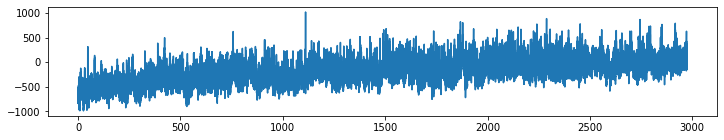

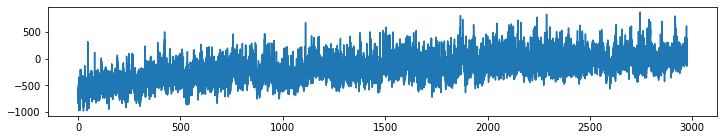

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0  -0.1067 -0.0598 -0.1681 -0.7407 -0.7891 -0.4280 -0.4501  0.0741 -2.2933   
5  -0.1043 -0.0506 -0.1661 -0.7928 -0.8219 -0.4280 -0.5200  0.1026 -2.5800   
10 -0.0895 -0.0916 -0.1738 -0.8588 -0.7812 -0.4166 -0.5000 -0.0036 -2.6600   
15 -0.0713 -0.0280 -0.1333 -0.8079 -0.7203 -0.3811 -0.3902  0.1332 -2.3667   
20 -0.0643 -0.0579 -0.1456 -0.8530 -0.7578 -0.3300 -0.3323  0.0905 -2.7000   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0  -1.6000  ... -0.1852 -0.8003 -0.3835 -0.4560 -0.0459 -0.4447 -0.3367   
5  -1.6531  ... -0.1814 -0.8164 -0.3423 -0.4329 -0.0172 -0.4974 -0.3427   
10 -1.5918  ... -0.2030 -0.6997 -0.2013 -0.2589  0.0615 -0.2987 -0.2020   
15 -1.5694  ... -0.0489 -0.6300 -0.0063 -0.1614  0.1639 -0.2697 -0.2020   
20 -1.6020  ... -0.0714 -0.5764  0.0079 -0.1256  0.1680 -0.4158 -0.1950   

        Oz      O2    PO10  
0  -0.5418 -0.5233 -0.1198  
5  -0.6088 -0.5416 -0.1029  
10 -0.4592 -0.3836 -0.0271  
15 -0.4331 -0.2877  0.0000  
20 -0.3766 -0.1918  0.0162  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



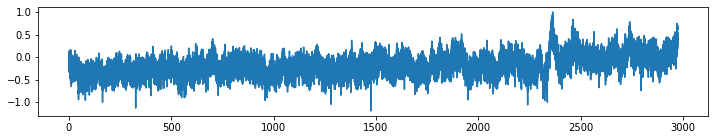



Channel 6 [After Low-Pass] -



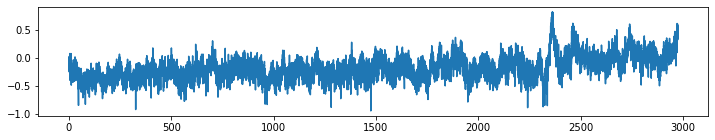



Channel 6 [Before vs After] -



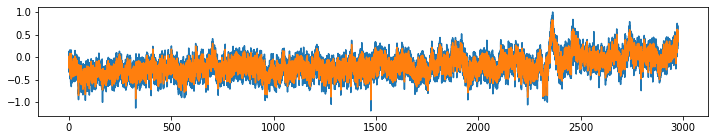

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0  0.000063 -0.001822  0.000196 -0.000988  0.000033 -0.000028  0.000253   
1  0.000347 -0.001750  0.000377 -0.000744  0.000077  0.000166  0.000013   
2  0.000611 -0.001678  0.000546 -0.000520  0.000117  0.000346 -0.000206   
3  0.000836 -0.001604  0.000691 -0.000332  0.000146  0.000497 -0.000387   

         8         9         10  ...        23        24        25        26  \
0 -0.001119 -0.001229 -0.001057  ... -0.001944 -0.001602 -0.000479 -0.001102   
1 -0.001123 -0.001329 -0.000898  ... -0.001994 -0.001499 -0.000464 -0.001258   
2 -0.001120 -0.001424 -0.000760  ... -0.002046 -0.001402 -0.000454 -0.001412   
3 -0.001104 -0.001517 -0.000658  ... -0.002096 -0.001311 -0.000455 -0.001556   

         27        28        29        30        31        32  
0 -0.002505 -0.007615  0.000063 -0.001345  0.002768  0.000211  
1 -0.001927 -0.007353 -0.000016 -0.001327  0.002643  0.000062  
2 -0.001390 -0.007113 -0.000084 -0.001325  0.002520 -0.000071  
3 -0.000936 -0.006914 -0.000132 -0.001352  0.002405 -0.000171  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0  2.793582 -0.450937  0.744020  0.133247  0.319188  0.544693 -0.473899   
1  2.739055 -0.548568  0.763183  0.104894  0.298754  0.535653 -0.457266   
2  2.690190 -0.637534  0.779632  0.077430  0.279848  0.527651 -0.441113   
3  2.653492 -0.709164  0.791120  0.051887  0.263620  0.521859 -0.426584   

          8  
0 -0.017622  
1 -0.045491  
2 -0.071476  
3 -0.093764

###Visualization

####Signals [Dimensions Reduced]

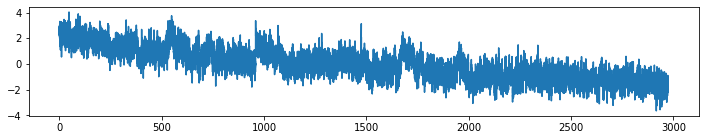

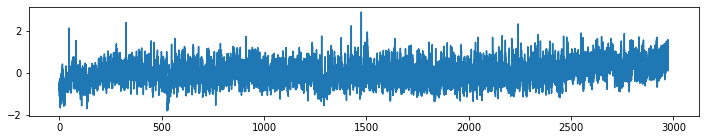

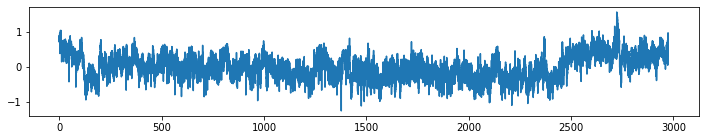

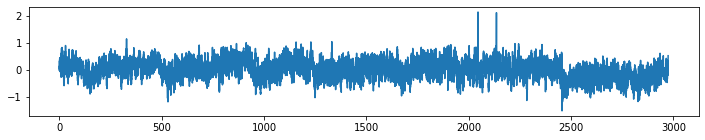

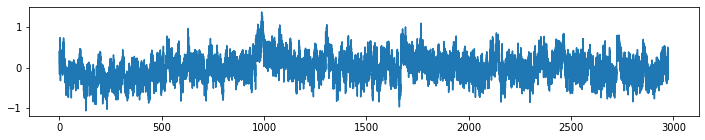

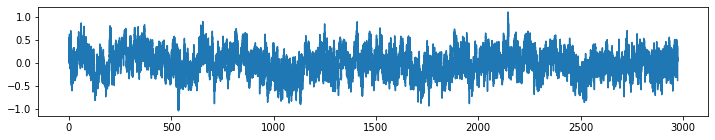

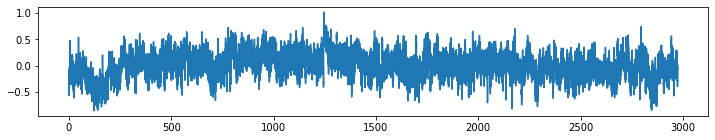

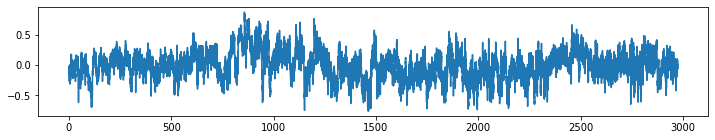

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

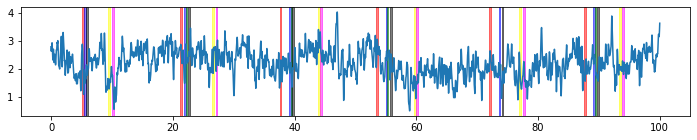

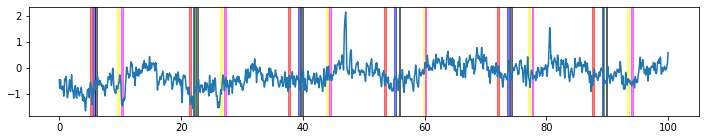

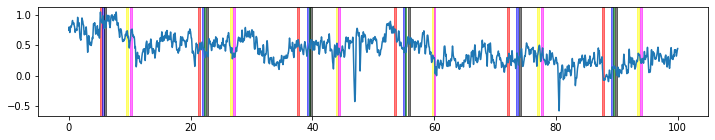

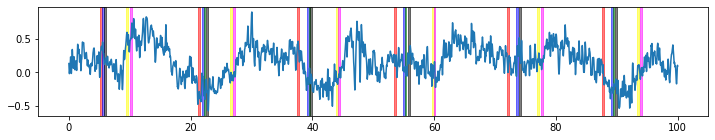

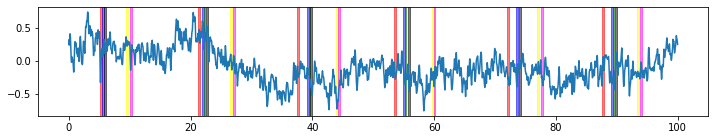

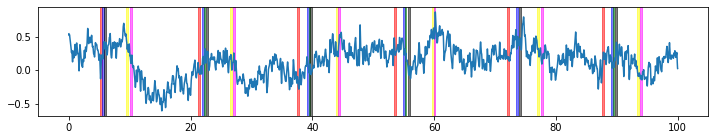

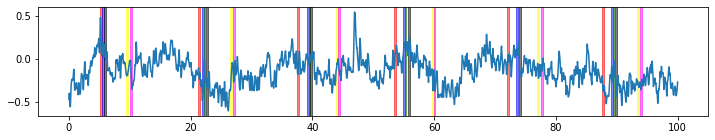

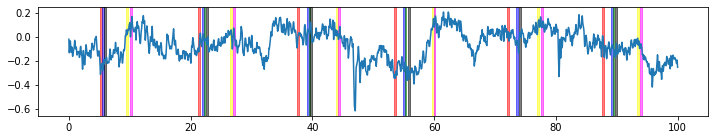

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (245472, 32)
x train : (245472, 6)
x val   : (51911, 32)
y val   : (51911, 6)


In [ ]:
x_train.to_csv(path+'x_train10.csv',index=False)
y_train.to_csv(path+'y_train10.csv',index=False)
x_val.to_csv(path+'x_val10.csv',index=False)
y_val.to_csv(path+'y_val10.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train10.csv')
y_train = pd.read_csv(path+'y_train10.csv')
x_val = pd.read_csv(path+'x_val10.csv')
y_val = pd.read_csv(path+'y_val10.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (245472, 32)
y train : (245472, 6)
x val   : (51911, 32)
y val   : (51911, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7809023702721649
0.7880642646262653
0.7595218801763453
0.7672071296887145
0.7252398049713358
0.6610407596697518

0.7469960349007629


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7597365467612323
0.7450074722195028
0.7069907763991883
0.6995597317549868
0.7120630884544872
0.6179740495183456

0.7068886108512905


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.8385404638083904
0.8336955226838184
0.8152241705167961
0.7950250764619777
0.7679298472411763
0.6824615743913415

0.7888127758505834


In [ ]:
probs1

array([[3.98111760e-04, 7.40972633e-05, 3.83009111e-05, 1.46507697e-04,
        6.89502285e-03, 8.54120016e-03],
       [2.04899563e-04, 9.80747417e-05, 5.05962380e-05, 1.98993558e-04,
        8.69688485e-03, 1.20745956e-02],
       [1.09184924e-04, 1.31212980e-04, 6.75774460e-05, 2.72508133e-04,
        1.10120230e-02, 1.69321233e-02],
       ...,
       [1.27674789e-02, 1.23527033e-04, 5.90872526e-05, 9.54606184e-05,
        3.78481483e-03, 2.55356140e-03],
       [1.85585291e-02, 1.52570377e-04, 7.42318265e-05, 1.11399605e-04,
        4.14069362e-03, 3.01338556e-03],
       [2.76070253e-02, 1.88124289e-04, 9.31948718e-05, 1.30176461e-04,
        4.53453365e-03, 3.56482633e-03]])

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.8446337531222711
0.8389603903561385
0.8187291545520776
0.8032279162592428
0.7615438419357236
0.6774056870647841

0.7907501238817063


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.8431996511784718
0.8040925096553028
0.7861875599831881
0.7799797251418464
0.7624203484204934
0.7052768249927951

0.7801927698953497


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.8189160829056614
0.7955839349836303
0.7906093800436499
0.7930339639013754
0.7695789597947017
0.6891274684765125

0.7761416316842552


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
7671/7671 [==============================] - 17s 2ms/step - loss: 1.7099 - accuracy: 0.1640
Epoch 2/5
7671/7671 [==============================] - 15s 2ms/step - loss: 0.4732 - accuracy: 0.1635
Epoch 3/5
7671/7671 [==============================] - 15s 2ms/step - loss: 0.3902 - accuracy: 0.1927
Epoch 4/5
7671/7671 [==============================] - 14s 2ms/step - loss: 0.5139 - accuracy: 0.1928
Epoch 5/5
7671/7671 [==============================] - 14s 2ms/step - loss: 0.6579 - accuracy: 0.1946


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [2.6606046e-12, 2.4527615e-12, 2.4306078e-12, 2.3200406e-12,
        2.3620077e-12, 2.3315969e-12],
       [2.6606046e-12, 2.4527615e-12, 2.4306078e-12, 2.3200406e-12,
        2.3620077e-12, 2.3315969e-12],
       [2.6606046e-12, 2.4527615e-12, 2.4306078e-12, 2.3200406e-12,
        2.3620077e-12, 2.3315969e-12]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
480/480 [==============================] - 1s 2ms/step - loss: 0.2054 - accuracy: 0.9763
Epoch 2/5
480/480 [==============================] - 1s 2ms/step - loss: 0.1170 - accuracy: 0.9765
Epoch 3/5
480/480 [==============================] - 1s 2ms/step - loss: 0.1105 - accuracy: 0.9765
Epoch 4/5
480/480 [==============================] - 1s 2ms/step - loss: 0.1061 - accuracy: 0.9765
Epoch 5/5
480/480 [==============================] - 1s 2ms/step - loss: 0.1040 - accuracy: 0.9765
0.849186725280636
Epoch 1/5
480/480 [==============================] - 2s 2ms/step - loss: 0.3770 - accuracy: 0.8824
Epoch 2/5
480/480 [==============================] - 1s 2ms/step - loss: 0.1934 - accuracy: 0.9765
Epoch 3/5
480/480 [==============================] - 1s 2ms/step - loss: 0.1708 - accuracy: 0.9765
Epoch 4/5
480/480 [==============================] - 1s 2ms/step - loss: 0.1554 - accuracy: 0.9765
Epoch 5/5
480/480 [==============================] - 1s 2ms/step - loss: 0.1413 - accuracy:

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.6147937413821777
0.60155623567628
0.5989864389340184
0.5856449394339356
0.531136759309607
0.5576998902265886

0.5816363341604346


# Subject 11

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj11_data.csv')
train_events = pd.read_csv(path+'Train/subj11_events.csv')
val_data = pd.read_csv(path+'Validation/subj11_data.csv')
val_events = pd.read_csv(path+'Validation/subj11_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1245565, 32)
Train Events      : (1245565, 6)
Validation Data   : (275472, 32)
Validation Events : (275472, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1245565


In [ ]:
x.head(4)

Fp1   Fp2   F7   F3   Fz   F4   F8  FC5  FC1  FC2  ...   P7  P3   Pz   P4  \
0 -3050 -1275 -823 -323 -337  584 -232  496  200  153  ... -197 -29 -112  328   
1 -3057 -1267 -908 -413 -320  545 -233  509  198  168  ... -337 -52 -101  374   
2 -3042 -1243 -967 -411 -330  559 -243  511  193  165  ... -146 -14  -67  412   
3 -2959 -1157 -833 -363 -327  631 -189  460  177  190  ...  -23  31  -72  409   

    P8  PO9   O1   Oz  O2  PO10  
0  549  -18 -784 -504 -20   -63  
1  601  -59 -778 -477 -22    16  
2  597  101 -714 -402  49   -37  
3  539   61 -728 -409  40   -65  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

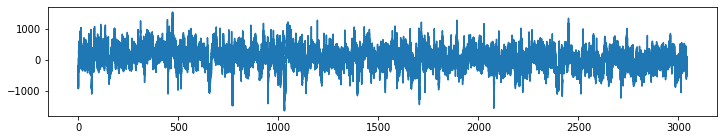

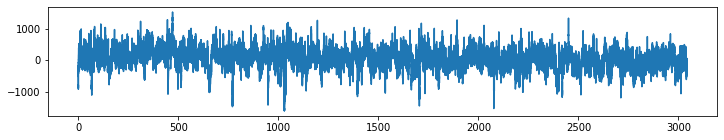

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0  -0.8994 -0.3191 -0.3376 -0.2111 -0.3225  0.3241 -0.1416  0.3302  0.4065   
5  -0.8723 -0.2748 -0.3425 -0.2693 -0.2890  0.3518 -0.0488  0.1884  0.3720   
10 -0.8800 -0.2740 -0.2818 -0.2085 -0.2967  0.3202 -0.1105  0.2370  0.3720   
15 -0.8983 -0.2618 -0.3167 -0.2399 -0.2900  0.4273 -0.0672  0.2437  0.3354   
20 -0.8859 -0.2808 -0.2477 -0.2000 -0.2708  0.3851 -0.0611  0.3276  0.4045   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0   0.3835  ... -0.1184 -0.0212 -0.1393  0.1846  0.2555 -0.0103 -0.6501   
5   0.5038  ...  0.0992  0.0394 -0.0871  0.2577  0.3490 -0.0063 -0.6070   
10  0.4812  ...  0.1617  0.1175  0.0323  0.3129  0.3806 -0.2291 -0.4983   
15  0.5338  ...  0.0024 -0.0445 -0.1219  0.2200  0.2583 -0.0166 -0.6799   
20  0.5664  ...  0.0992  0.0504 -0.0883  0.2409  0.2531  0.0653 -0.5597   

        Oz      O2    PO10  
0  -0.5780 -0.0141 -0.0328  
5  -0.5654 -0.0183 -0.0931  
10 -0.1823  0.3308  0.2867  
15 -0.5677  0.0099 -0.0088  
20 -0.3521  0.1879  0.0489  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



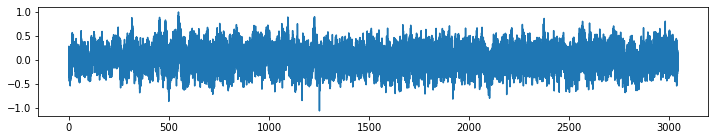



Channel 6 [After Low-Pass] -



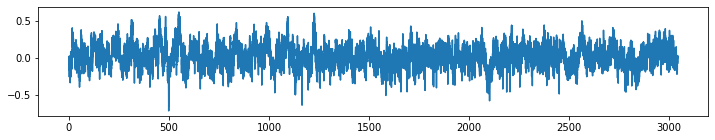



Channel 6 [Before vs After] -



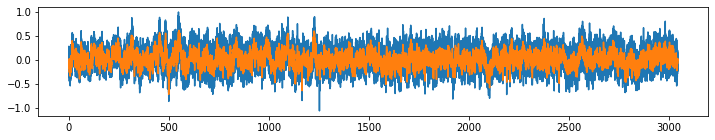

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0 -0.003263  0.001756 -0.000896  0.000512 -0.003688 -0.005047 -0.007384   
1 -0.002926  0.001535 -0.000922  0.000258 -0.003667 -0.004263 -0.007242   
2 -0.002618  0.001333 -0.000951  0.000028 -0.003644 -0.003530 -0.007105   
3 -0.002364  0.001158 -0.000980 -0.000162 -0.003618 -0.002884 -0.006981   

         8         9         10  ...        23        24        25        26  \
0  0.002406 -0.001735 -0.000110  ... -0.003874 -0.002846 -0.002446  0.005053   
1  0.002509 -0.001580 -0.000217  ... -0.004211 -0.002697 -0.002157  0.004767   
2  0.002616 -0.001440 -0.000302  ... -0.004534 -0.002552 -0.001887  0.004489   
3  0.002728 -0.001323 -0.000354  ... -0.004832 -0.002412 -0.001648  0.004225   

         27        28        29        30        31        32  
0 -0.001737 -0.002661  0.000014  0.000475  0.000888  0.002291  
1 -0.001902 -0.002690  0.000051  0.000693  0.000652  0.002276  
2 -0.002067 -0.002700  0.000086  0.000890  0.000431  0.002256  
3 -0.002226 -0.002679  0.000118  0.001050  0.000238  0.002231  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0  0.133525  0.955716  0.090505  0.074113 -0.573993 -0.072114  0.114852   
1  0.070454  0.890866  0.056713  0.066741 -0.574721 -0.107592  0.104803   
2  0.010071  0.829937  0.025348  0.059349 -0.575166 -0.140480  0.095402   
3 -0.045719  0.775727 -0.002052  0.051965 -0.575299 -0.168685  0.086949   

          8  
0  0.786210  
1  0.771361  
2  0.757946  
3  0.746481

###Visualization

####Signals [Dimensions Reduced]

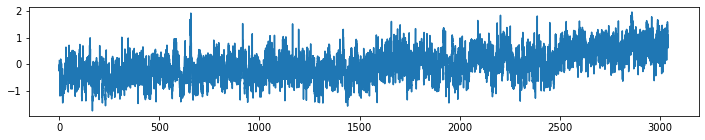

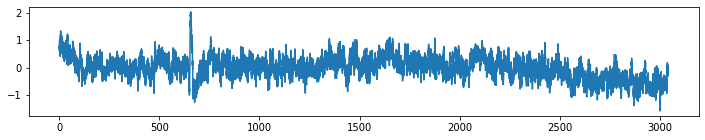

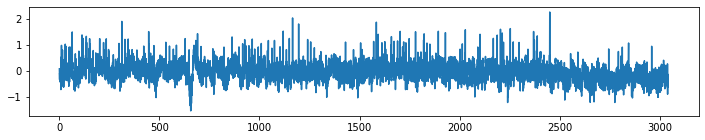

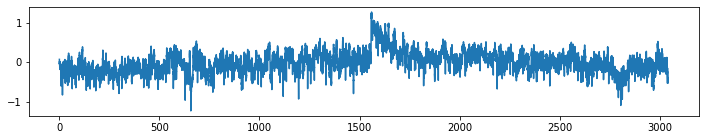

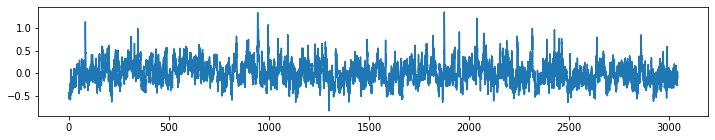

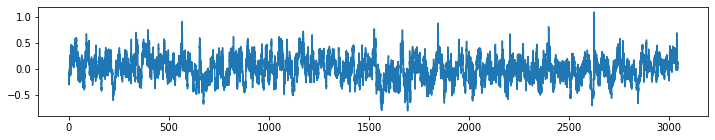

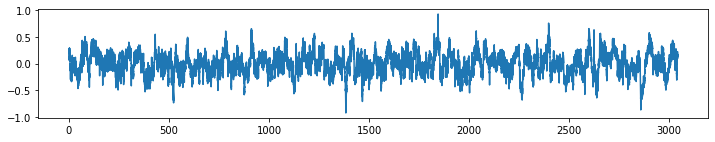

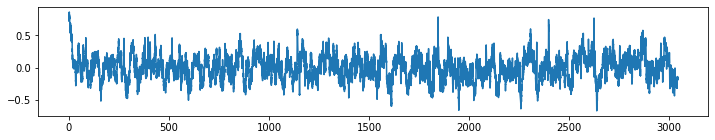

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

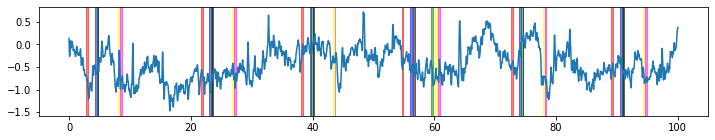

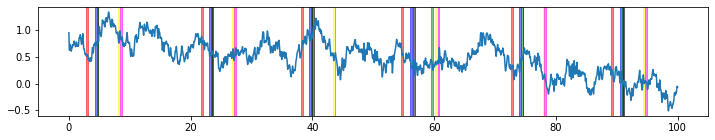

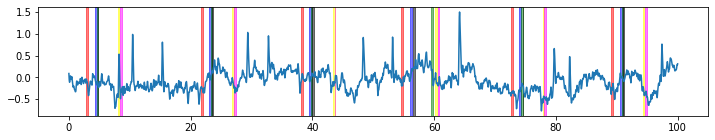

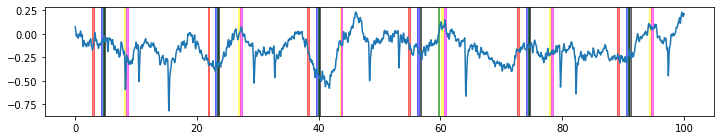

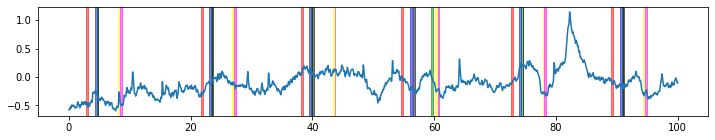

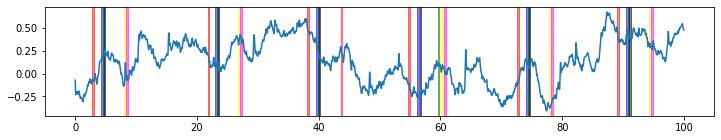

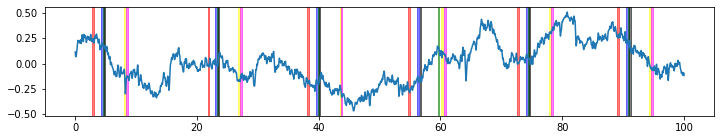

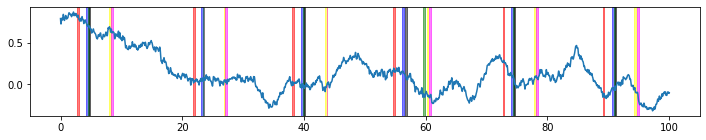

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (249113, 32)
x train : (249113, 6)
x val   : (55095, 32)
y val   : (55095, 6)


In [ ]:
x_train.to_csv(path+'x_train11.csv',index=False)
y_train.to_csv(path+'y_train11.csv',index=False)
x_val.to_csv(path+'x_val11.csv',index=False)
y_val.to_csv(path+'y_val11.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train11.csv')
y_train = pd.read_csv(path+'y_train11.csv')
x_val = pd.read_csv(path+'x_val11.csv')
y_val = pd.read_csv(path+'y_val11.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.808255519152341
0.640071928686657
0.6873419924939159
0.6815055685831019
0.7031146830610483
0.7124716858753679

0.705460229642072


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.8114539573250843
0.6424608480655479
0.6637966150554087
0.668007238141699
0.7102477497454546
0.6986312437518595

0.6990996086808422


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.8376563813726414
0.6792039060464445
0.7078359859635118
0.7643381082524423
0.7454926075604118
0.7163161147976295

0.7418071839988469


In [ ]:
probs1

array([[0.01314602, 0.02156459, 0.02346158, 0.03040236, 0.02461307,
        0.03037381],
       [0.01263108, 0.02594832, 0.03027164, 0.04411752, 0.02769474,
        0.03411826],
       [0.01209406, 0.03037596, 0.03767241, 0.06080202, 0.03073817,
        0.03774395],
       ...,
       [0.02148632, 0.00893632, 0.00747508, 0.01182056, 0.00703741,
        0.00710046],
       [0.02410063, 0.00846642, 0.00709286, 0.01071555, 0.00714592,
        0.0072282 ],
       [0.02722013, 0.00801905, 0.00672779, 0.00967542, 0.0072805 ,
        0.00738732]])

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.8361475050862868
0.6790915919661616
0.7071829825135219
0.772332457438729
0.7356457597646542
0.7123251583170259

0.7404542425143966


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.8059340889310205
0.6855689157200907
0.7053244182415214
0.7571396451333338
0.7430526220477823
0.7223027527852155

0.7365537404764941


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.7830085085584513
0.6745166503129383
0.6724487398389758
0.7549945302784198
0.7149748272695187
0.7162372057483817

0.7193634103344476


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
7785/7785 [==============================] - 15s 2ms/step - loss: 1.0162 - accuracy: 0.1627
Epoch 2/5
7785/7785 [==============================] - 15s 2ms/step - loss: 0.3746 - accuracy: 0.1789
Epoch 3/5
7785/7785 [==============================] - 15s 2ms/step - loss: 0.2796 - accuracy: 0.1960
Epoch 4/5
7785/7785 [==============================] - 14s 2ms/step - loss: 0.2953 - accuracy: 0.1867
Epoch 5/5
7785/7785 [==============================] - 15s 2ms/step - loss: 0.3412 - accuracy: 0.1777


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
487/487 [==============================] - 1s 2ms/step - loss: 0.3238 - accuracy: 0.9349
Epoch 2/5
487/487 [==============================] - 1s 2ms/step - loss: 0.1457 - accuracy: 0.9768
Epoch 3/5
487/487 [==============================] - 1s 2ms/step - loss: 0.1283 - accuracy: 0.9769
Epoch 4/5
487/487 [==============================] - 1s 2ms/step - loss: 0.1199 - accuracy: 0.9770
Epoch 5/5
487/487 [==============================] - 1s 2ms/step - loss: 0.1145 - accuracy: 0.9769
0.8115614946383793
Epoch 1/5
487/487 [==============================] - 2s 2ms/step - loss: 0.3340 - accuracy: 0.9460
Epoch 2/5
487/487 [==============================] - 1s 2ms/step - loss: 0.1566 - accuracy: 0.9769
Epoch 3/5
487/487 [==============================] - 1s 2ms/step - loss: 0.1435 - accuracy: 0.9769
Epoch 4/5
487/487 [==============================] - 1s 2ms/step - loss: 0.1374 - accuracy: 0.9769
Epoch 5/5
487/487 [==============================] - 1s 2ms/step - loss: 0.1318 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7125165385162641
0.517873082132674
0.5299651628628079
0.5532376594026547
0.5318495050456333
0.5395882694798776

0.564171702906652


# Subject 12

##Preprocessing

###Importing

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

train_data = pd.read_csv(path+'Train/subj12_data.csv')
train_events = pd.read_csv(path+'Train/subj12_events.csv')
val_data = pd.read_csv(path+'Validation/subj12_data.csv')
val_events = pd.read_csv(path+'Validation/subj12_events.csv')

print("Train Data        :",train_data.shape)
print("Train Events      :",train_events.shape)
print("Validation Data   :",val_data.shape)
print("Validation Events :",val_events.shape)

Train Data        : (1305410, 32)
Train Events      : (1305410, 6)
Validation Data   : (302513, 32)
Validation Events : (302513, 6)


In [ ]:
n_train = train_data.shape[0]
n_val = val_data.shape[0]

x = pd.concat([train_data,val_data],axis=0)
y = pd.concat([train_events,val_events],axis=0)

print(n_train)

1305410


In [ ]:
x.head(4)

Fp1  Fp2   F7   F3   Fz   F4   F8  FC5  FC1  FC2  ...   P7  P3  Pz   P4  \
0 -542  114 -263 -362 -198  339 -333  131   50 -134  ...  -66 -26  -5  144   
1 -570   80 -285 -426 -222  347 -425  140   37 -159  ... -124 -61 -16  135   
2 -635   44 -325 -444 -217  227 -499  150   40 -150  ...  139  -9  -4  118   
3 -618   71 -393 -449 -185  242 -371  147   40 -129  ...  210   1  12  124   

    P8  PO9  O1   Oz   O2  PO10  
0  -90 -630 -96 -243 -215   -61  
1  -99 -476 -70 -200 -191     1  
2 -106 -509 -64 -209 -189    25  
3 -127 -424 -91 -248 -228   -13  

[4 rows x 32 columns]

In [ ]:
y.head(4)

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  \
0          0                0                   0        0        0   
1          0                0                   0        0        0   
2          0                0                   0        0        0   
3          0                0                   0        0        0   

   BothReleased  
0             0  
1             0  
2             0  
3             0

In [ ]:
from matplotlib import pyplot as plt

def plot_signal(x,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

###Downsampling

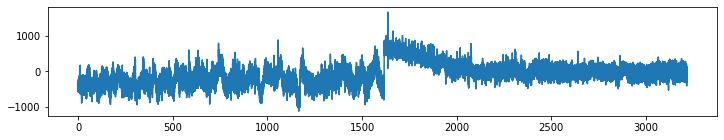

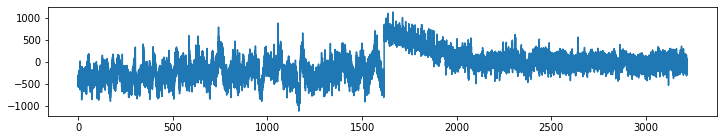

In [ ]:
fs = 500

factor = 5

plot_signal(x.iloc[:,3],500)

x = x.iloc[::factor]
y = y.iloc[::factor]

plot_signal(x.iloc[:,3],int(500/factor))

n_train = n_train//factor 

###Normalization

In [ ]:
# convert to ints or floats if saved as str 
def str_to_num(df) : 
  for col in df : 
    try : df[col] = pd.to_numeric(df[col])
    except : pass

# Dividing by largest
def normalize_dbl(df,cols,round=None) : 
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Dividing by constant
def normalize_dbc(df,cols,round=None,c=1) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(c).round(round)


# min-max normalization
def normalize_rescale(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    df[col] = df[col] - m
    l = l - m
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# mean normalization
def normalize_mean(df,cols,round=None) :
  if(type(cols)!=list) : cols = [cols]
  for col in cols : 
    l = max(df[col])
    m = min(df[col])
    mean = df[col].sum()
    n = df[col].shape[0]
    mean = mean/n
    l = l - m
    for i in range(n) : df.at[i,col] = df.at[i,col] - mean
    if round is None : df[col] = df[col].div(l)
    else : df[col] = df[col].div(l).round(round)

# Combining above normalization functions
def normalize(df,cols=None,kinds=None,round=None,c=1,exceptions=[]) :
  if(cols is None) : 
    cols = []
    for col in df : 
      if(pd.api.types.is_numeric_dtype(df[col])) : 
        if(max(df[col])>1 or min(df[col])<-1) : 
          if(col not in exceptions) : cols.append(col)
  if(type(cols)!=list) : cols = [cols]
  n = len(cols)
  if(kinds is None) : kinds = 'dbl'
  if(type(kinds)!=list) : kinds = [kinds]*n
  for i,kind in enumerate(kinds) : 
    if(kind=='dbl') : normalize_dbl(df,cols[i],round)
    if(kind=='dbc') : normalize_dbc(df,cols[i],round,c)
    if(kind=='dblc') : normalize_dblc(df,cols[i],round,c)
    if(kind in ['min-max','rescale','scale']) : normalize_rescale(df,cols[i],round)
    if(kind=='mean') : normalize_mean(df,cols[i],round)

str_to_num(x)
normalize(x,kinds='dbl',round=4)

x.head()

Fp1     Fp2      F7      F3      Fz      F4      F8     FC5     FC1  \
0  -0.1097  0.0265 -0.0757 -0.3178 -0.3486  0.3244 -0.0613  0.0881  0.0386   
5  -0.1049  0.0144 -0.0587 -0.4504 -0.3556  0.3005 -0.0432  0.0605  0.0201   
10 -0.1257  0.0026 -0.1039 -0.4759 -0.3873  0.3139 -0.0548 -0.0282  0.0031   
15 -0.1421 -0.0312 -0.0918 -0.4434 -0.3979  0.3120 -0.0732  0.0182  0.0162   
20 -0.1217 -0.0186 -0.1022 -0.4486 -0.4401  0.1684 -0.0710  0.0424  0.0309   

       FC2  ...      P7      P3      Pz      P4      P8     PO9      O1  \
0  -0.4653  ... -0.0502 -0.0349 -0.0062  0.1688 -0.0697 -0.3393 -0.0789   
5  -0.3750  ... -0.1766 -0.0685  0.0037  0.1407 -0.1061 -0.1610 -0.0707   
10 -0.4514  ... -0.1948 -0.2016 -0.0748  0.0528 -0.1805 -0.3301 -0.2467   
15 -0.4306  ... -0.1956 -0.1465  0.0025  0.1630 -0.1247 -0.3861 -0.1974   
20 -0.5868  ... -0.0533 -0.0403  0.0287  0.1805 -0.1518 -0.2859 -0.1266   

        Oz      O2    PO10  
0  -0.2480 -0.2544 -0.0418  
5  -0.2898 -0.3657 -0.1131  
10 -0.4520 -0.4982 -0.1748  
15 -0.4051 -0.4178 -0.2659  
20 -0.2908 -0.3172 -0.0562  

[5 rows x 32 columns]

###Low-Pass Filter

Channel 6 [Before Low-Pass] -



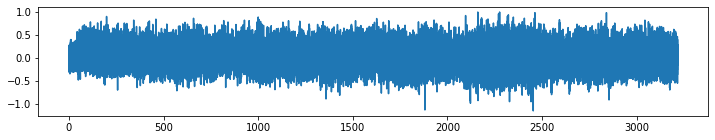



Channel 6 [After Low-Pass] -



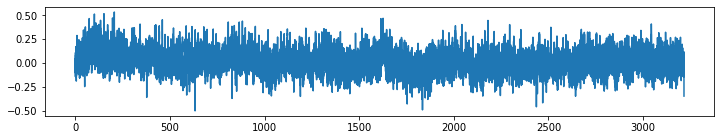



Channel 6 [Before vs After] -



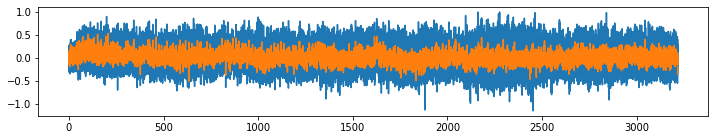

In [ ]:
try : 
  fs = 500//factor
except : fs = 500

# EDIT
cutoff = 5    
nyq = 0.5*fs  
order = 2    
# EDIT 

from scipy.signal import butter,filtfilt

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
  

x_lp = x.copy()

for i in range(x_lp.shape[1]) : 
  x_lp.iloc[:,i] = butter_lowpass_filter(x.iloc[:,i],cutoff,fs,order)


ch = 5

print(f"Channel {ch+1} [Before Low-Pass] -")
print()
plot_signal(x.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [After Low-Pass] -")
print()
plot_signal(x_lp.iloc[:,i],fs)

print('\n')

print(f"Channel {ch+1} [Before vs After] -")
print()
plot_signal(x.iloc[:,i],fs,show=False)
plot_signal(x_lp.iloc[:,i],fs,show=True)

###ICA

In [ ]:
from sklearn.decomposition import FastICA 

ica = FastICA(n_components=x.shape[1],random_state=42)

x_ica = ica.fit_transform(x_lp)

x_ica = pd.DataFrame(x_ica,columns=list(range(1,x.shape[1]+1)))

x_ica.head(4)

1         2         3         4         5         6         7   \
0  0.000413  0.000948 -0.001925  0.002064 -0.001445 -0.000800  0.006735   
1  0.000424  0.001082 -0.001937  0.001815 -0.001172 -0.001177  0.006641   
2  0.000444  0.001211 -0.001951  0.001576 -0.000913 -0.001530  0.006552   
3  0.000472  0.001331 -0.001968  0.001357 -0.000689 -0.001836  0.006474   

         8         9         10  ...        23        24        25        26  \
0 -0.003336  0.000435  0.001032  ...  0.000757  0.003407 -0.001765 -0.001007   
1 -0.003495  0.000250  0.001365  ...  0.000707  0.003048 -0.001904 -0.000846   
2 -0.003635  0.000084  0.001664  ...  0.000657  0.002724 -0.002037 -0.000697   
3 -0.003750 -0.000050  0.001898  ...  0.000611  0.002468 -0.002155 -0.000574   

         27        28        29        30        31        32  
0 -0.005711 -0.000165 -0.002636 -0.001535  0.000473  0.002664  
1 -0.005575 -0.000208 -0.002425 -0.001221  0.000151  0.002813  
2 -0.005449 -0.000256 -0.002239 -0.000927 -0.000141  0.002966  
3 -0.005337 -0.000318 -0.002095 -0.000674 -0.000384  0.003120  

[4 rows x 32 columns]

###Dimension Reduction 

In [ ]:
# EDIT
nc = 8
# EDIT

from sklearn.decomposition import PCA

pca = PCA(n_components=nc)

x_dr = pca.fit_transform(x_lp)

x_dr = pd.DataFrame(x_dr,columns=list(range(1,nc+1)))

x_dr.head(4)

1         2         3         4         5         6         7  \
0  1.054590  0.003462 -0.043881 -0.030944  0.412143 -0.215759 -0.191419   
1  1.059589 -0.003074 -0.056641 -0.020187  0.411792 -0.205645 -0.220792   
2  1.060580 -0.010954 -0.069238 -0.011121  0.411031 -0.195294 -0.248157   
3  1.055405 -0.020929 -0.081271 -0.004734  0.409818 -0.185209 -0.271729   

          8  
0 -0.261238  
1 -0.274867  
2 -0.287170  
3 -0.296983

###Visualization

####Signals [Dimensions Reduced]

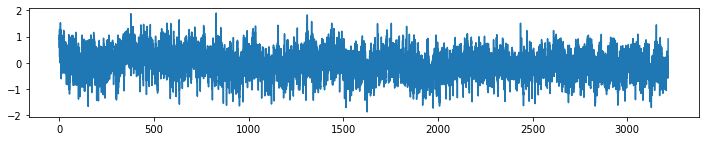

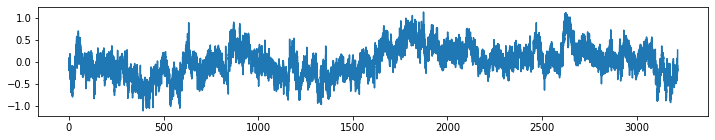

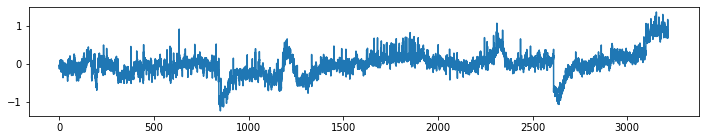

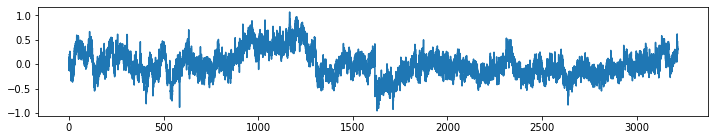

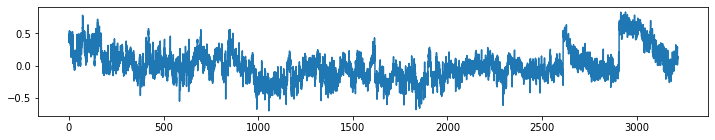

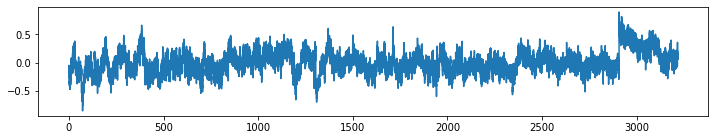

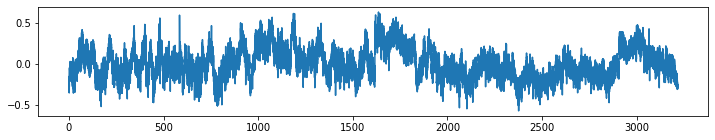

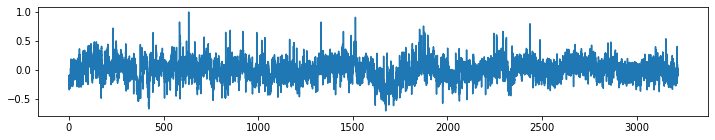

In [ ]:
for i in range(x_dr.shape[1]) :
  plot_signal(x_dr.iloc[:,i],fs)

####Activities [0-20 sec]

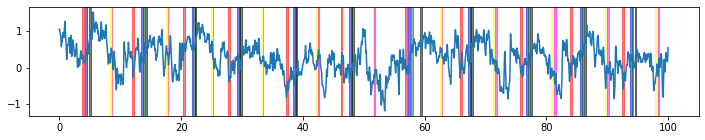

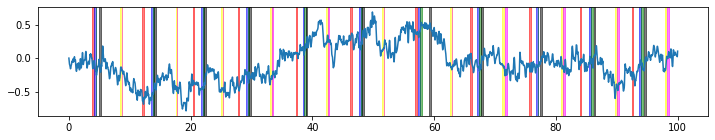

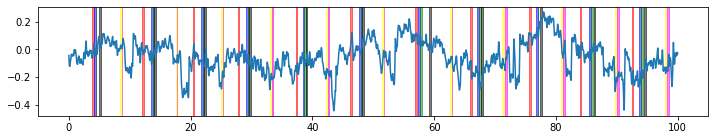

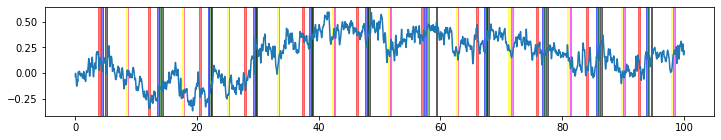

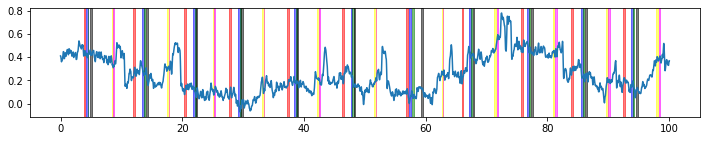

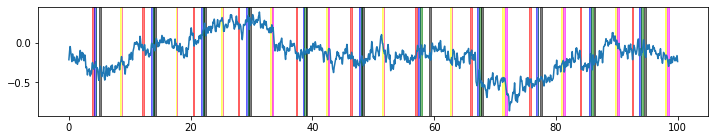

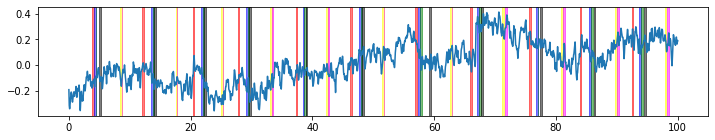

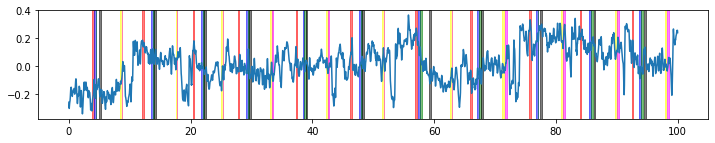

In [ ]:
# TODO : Color Visualize Classes

def plot_signal_activities(x,y,fr,sig=-1,title=None,show=None) :
  if(sig>=0) : x = x[sig]
  timing = np.linspace(0,len(x)/fr,num=len(x))
  if(show!=True) : plt.figure(figsize=(12,2))
  plt.plot(timing,x)
  a = 0
  b = 0 
  grp = False
  c = y.shape[1]
  d = None
  n = y.shape[0]
  clr = ['red','blue','green','black','yellow','magenta']
  while(a<n) : 
    for i in range(c) : 
      if(y.iloc[a,i]==1) : 
        b = a+1 
        grp = True
        d = i
        break
    if(grp) : 
      while(b<n) : 
        if(y.iloc[b,d]!=1) : break
        b = b + 1
      plt.axvspan(a/fs,b/fs,color=clr[d],alpha=0.5)
      a = b
      grp = False
    a  = a + 1
  if title is not None : plt.title(title)
  if(show!=False) : plt.show()

for i in range(x_dr.shape[1]) :
  x_v = x_dr.iloc[:10000,i]
  y_v = y.iloc[:10000,:]
  plot_signal_activities(x_v,y_v,fs)

###Splitting

In [ ]:
x_train = x_lp.iloc[:n_train,:]
y_train = y.iloc[:n_train,:]
x_val = x_lp.iloc[n_train:,:]
y_val = y.iloc[n_train:,:]

print("x train :",x_train.shape)
print("x train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (261082, 32)
x train : (261082, 6)
x val   : (60503, 32)
y val   : (60503, 6)


In [ ]:
x_train.to_csv(path+'x_train12.csv',index=False)
y_train.to_csv(path+'y_train12.csv',index=False)
x_val.to_csv(path+'x_val12.csv',index=False)
y_val.to_csv(path+'y_val12.csv',index=False)

## Importing Preprocessed Data





In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import time
import warnings
warnings.filterwarnings("ignore") 

x_train = pd.read_csv(path+'x_train12.csv')
y_train = pd.read_csv(path+'y_train12.csv')
x_val = pd.read_csv(path+'x_val12.csv')
y_val = pd.read_csv(path+'y_val12.csv')

print("x train :",x_train.shape)
print("y train :",y_train.shape)
print("x val   :",x_val.shape)
print("y val   :",y_val.shape)

x train : (261082, 32)
y train : (261082, 6)
x val   : (60503, 32)
y val   : (60503, 6)


##Models

In [ ]:
from sklearn.metrics import roc_auc_score as auc
import tensorflow as tf

###Naive Bayes

#### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = GaussianNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.7454873167644493
0.5430118529802492
0.5750800489533685
0.6415375754667021
0.6703146753116518
0.6546218691023953

0.6383422230964694


#### Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB

aucs = []

for i in range(y_train.shape[1]) : 
  nb = BernoulliNB()
  nb.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],nb.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.722922852496283
0.5298748236273454
0.5615075841499215
0.6861712100128354
0.6698920517183149
0.6521850127766414

0.6370922557968902


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

aucs = []
probs1 = np.zeros(y_val.shape)
for i in range(y_train.shape[1]) : 
  lr = LR()
  lr.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lr.predict_proba(x_val)[:,1]))
  probs1[:,i] = lr.predict_proba(x_val)[:,1]
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.8341781612838419
0.5008261467869908
0.5223091662130531
0.6819087101511833
0.7049610227752563
0.640277510864086

0.6474101196790686


In [ ]:
probs1

####Best Threshold

In [ ]:
# best = [0]*probs1.shape[1]
# th_best = [0]*probs1.shape[1]
# n_rows = y_val.shape[0]

# for i in range(probs1.shape[1]) : 
#   for th in np.linspace(0,1,num=200) : 
#     a = probs1[:,i].copy()
#     for j in range(len(a)) : 
#       if(a[j]<th) : a[j] = 0
#       else : a[j] = 1
#     a = list(a.astype('int'))
#     acc = sum([y_val.iloc[j,i]==a[j] for j in range(n_rows)])/n_rows
#     if(acc>best[i]) : 
#       best[i] = acc
#       th_best[i] = th
#   print(best[i],th_best[i])

# print(best)
# print(th_best)

###LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

for i in range(y_train.shape[1]) : 
  lda = LDA()
  lda.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],lda.predict_proba(x_val)[:,1]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.8346930419876758
0.5012667053034716
0.5271350691722902
0.6752261192180206
0.7055997458422674
0.6492132111041911

0.6488556487713194


###CNN

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 128

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((32,1)),                            
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Conv1D(8,(5),activation='relu'),
    tf.keras.layers.MaxPooling1D((3)),
    tf.keras.layers.Dense(6,activation='sigmoid'),
    tf.keras.layers.Flatten()]
    )

loss_fn = 'binary_crossentropy'
cnn.compile(optimizer='adam',
            loss=loss_fn,
            metrics=['accuracy'])

cnn.fit(x_train,y_train,epochs=10,batch_size=BATCH_SIZE)

print(auc(y_val,cnn.predict(x_val,batch_size=BATCH_SIZE)))

###XGBoost

In [ ]:
import xgboost as xgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = xgb.XGBClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

0.8244118787381193
0.550399737491083
0.6077317923218071
0.6520785729066784
0.7492177137006043
0.7401389826580446

0.6873297796360561


###LightGBM

In [ ]:
import lightgbm as lgb
aucs = []
for i in range(y_train.shape[1]) : 
  DT = lgb.LGBMClassifier()
  DT.fit(x_train,y_train.iloc[:,i])
  aucs.append(auc(y_val.iloc[:,i],DT.predict_proba(x_val)[:,1]))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))


0.7922949800996977
0.5685553381676294
0.5986768738934262
0.669391752048304
0.7176019490121621
0.7112491837471865

0.6762950128280677


###MLP

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

mlp = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(n),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(c, activation='sigmoid')])

loss_fn = 'categorical_crossentropy'
mlp.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

mlp.fit(x_train,y_train,epochs=5)

pred = mlp.predict(x_val)

pred

Epoch 1/5
8159/8159 [==============================] - 19s 2ms/step - loss: 0.9915 - accuracy: 0.1821
Epoch 2/5
8159/8159 [==============================] - 19s 2ms/step - loss: 0.3543 - accuracy: 0.1752
Epoch 3/5
8159/8159 [==============================] - 19s 2ms/step - loss: 0.2653 - accuracy: 0.1865
Epoch 4/5
8159/8159 [==============================] - 16s 2ms/step - loss: 0.2678 - accuracy: 0.2158
Epoch 5/5
8159/8159 [==============================] - 16s 2ms/step - loss: 0.3021 - accuracy: 0.1941


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
n = x_train.shape[1]
c = y_train.shape[1]

BATCH_SIZE = 512
aucs = []
for i in range(y_train.shape[1]) : 

  mlp = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(n),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])

  loss_fn = 'binary_crossentropy'
  mlp.compile(optimizer='adam',
                loss=loss_fn,
                metrics=['accuracy'])

  mlp.fit(x_train,y_train.iloc[:,i],epochs=5,batch_size=BATCH_SIZE)

  aucs.append(auc(y_val.iloc[:,i],mlp.predict(x_val,batch_size=BATCH_SIZE)))
  print(aucs[-1])
print()
print(sum(aucs)/len(aucs))

Epoch 1/5
510/510 [==============================] - 2s 2ms/step - loss: 0.2274 - accuracy: 0.9779
Epoch 2/5
510/510 [==============================] - 1s 2ms/step - loss: 0.1242 - accuracy: 0.9779
Epoch 3/5
510/510 [==============================] - 1s 3ms/step - loss: 0.1163 - accuracy: 0.9779
Epoch 4/5
510/510 [==============================] - 1s 2ms/step - loss: 0.1117 - accuracy: 0.9779
Epoch 5/5
510/510 [==============================] - 1s 2ms/step - loss: 0.1089 - accuracy: 0.9779
0.7415657020210201
Epoch 1/5
510/510 [==============================] - 2s 2ms/step - loss: 0.3740 - accuracy: 0.9517
Epoch 2/5
510/510 [==============================] - 1s 2ms/step - loss: 0.1951 - accuracy: 0.9779
Epoch 3/5
510/510 [==============================] - 1s 3ms/step - loss: 0.1713 - accuracy: 0.9779
Epoch 4/5
510/510 [==============================] - 1s 2ms/step - loss: 0.1570 - accuracy: 0.9779
Epoch 5/5
510/510 [==============================] - 1s 2ms/step - loss: 0.1448 - accuracy

##Meta Model

In [ ]:
class Meta :  

  def __init__(self,models,final_model) : 
    self.models = models
    self.n = len(self.models)
    self.final_model = final_model

  def add(self,model) :
    self.models.append(model)
    self.n = self.n + 1

  def train(self,x,y) : 
    pr = pd.DataFrame()
    for i in range(self.n) : 
      m = self.models[i]
      m.fit(x,y)
      pr[i] = m.predict_proba(x)[:,1]
      self.final_model.fit(pr,y)
      
  def predict(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict(pr)

  def predict_proba(self,x) : 
    pr = pd.DataFrame()
    for i in range(self.n) :
      pr[i] = self.models[i].predict_proba(x)[:,1]
    return self.final_model.predict_proba(pr)

In [ ]:
from lightgbm import LGBMClassifier as LGB
from xgboost import XGBClassifier as XGB
from sklearn.ensemble import RandomForestClassifier as RFC
import tensorflow as tf
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

aucs = []

probs1 = np.zeros(y_val.shape)

for i in range(y_train.shape[1]) : 

  meta = Meta([],RFC())

  meta.add(LR())
  meta.add(LDA())
  meta.add(GaussianNB())
  meta.add(LGB())

  meta.train(x_train,y_train.iloc[:,i])

  probs1[:,i] = meta.predict_proba(x_val)[:,1]
  aucs.append(auc(y_val.iloc[:,i],probs1[:,i]))
  print(aucs[-1])

print()
print(sum(aucs)/len(aucs))

0.5668126614688089
0.49645417178554024
0.5143795153831164
0.5150989791431685
0.5220255152160929
0.523779746063624

0.5230917648433918
